Comenzamos por importar las bibliotecas que necesitaremos

In [1]:
# INHIBIENDO WARNINGS
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn import metrics



# 1. Carga de datos

Lectura del dataset Covid-20 a través de un archivo .csv.

Se trata de un dataset donde el objetivo es analizar y predecir el impacto económico de la enfermedad conocida como SARS-CoV-2 en diversos países de la Unión Europea. 
El impacto económico se mide a través de los datos diarios de la bolsa que presentaron los países durante la evolución de los brotes COVID. Este análisis nos permitirá predecir cual será el impacto de nuevos brotes en las economías de estos países.
Los países elegidos para el presente estudio son España, Portugal, Alemania, Suecia, Ucrania y Bulgaria. Todos los países han sido elegidos en función de diversas caracteríticas que atienden a su lozalización geográfica en Europa, las medidas implementadas para frenar el avance de la enfermedad, políticas de cuarentena y convivencia y desempeño a lo largo de la enfermedad.
Dado que la variable bolsa es una variable continua, se trata de un problema de regresión múltiple en donde el valor de la variable dependiente, en este caso, la bolsa se determinará a partir de un conjunto de variables independientes que analizaremos a lo largo de este proyecto.

In [2]:
data= pd.read_csv('full_grouped.csv', sep=',')

In [3]:
data.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Afghanistan,0,0,0,0,0,0,0,Eastern Mediterranean
1,2020-01-22,Albania,0,0,0,0,0,0,0,Europe
2,2020-01-22,Algeria,0,0,0,0,0,0,0,Africa
3,2020-01-22,Andorra,0,0,0,0,0,0,0,Europe
4,2020-01-22,Angola,0,0,0,0,0,0,0,Africa


Filtramos el dataset por los países que vamos a usar para el estudio. En este caso: España, Portugal, Alemania, Suecia, Ucrania y Letonia

In [4]:
filter_list = ['Bulgaria', 'Ukraine', 'Portugal', 'Spain', 'Sweden', 'Germany']
data = data[data['Country/Region'].isin(filter_list)]

In [5]:
data = data.reset_index(drop=True)
data

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Bulgaria,0,0,0,0,0,0,0,Europe
1,2020-01-22,Germany,0,0,0,0,0,0,0,Europe
2,2020-01-22,Portugal,0,0,0,0,0,0,0,Europe
3,2020-01-22,Spain,0,0,0,0,0,0,0,Europe
4,2020-01-22,Sweden,0,0,0,0,0,0,0,Europe
...,...,...,...,...,...,...,...,...,...,...
1123,2020-07-27,Germany,207112,9125,190314,7673,445,1,259,Europe
1124,2020-07-27,Portugal,50299,1719,35375,13205,135,2,158,Europe
1125,2020-07-27,Spain,272421,28432,150376,93613,0,0,0,Europe
1126,2020-07-27,Sweden,79395,5700,0,73695,398,3,0,Europe


Eliminamos los resgistros de los meses anteriores a Marzo, ya que en nuestros países seleccionados aún no había casos de Covis-19

In [6]:
data['month'] = pd.DatetimeIndex(data['Date']).month

In [7]:
data.drop(data[data['month']< 3 ].index, inplace=True)

Transformamos la variable Fecha

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")

### Carga de la variable independiente

A continuación cargaremos los datos de la bolsa de los países y haremos un mapeo con los campos "Country" y "Date" con el fin de unir ambos dataset y asignarle a cada país su valor de bolsa correspondiente por día del mes.

In [9]:
data_bolsa= pd.read_csv('Datos_historicos_bolsa.csv', sep=',', decimal=',')

In [10]:
data_bolsa

,Date,Bolsa,Country/Region
0,27.07.2020,"7.170,60",Spain
1,24.07.2020,"7.294,70",Spain
2,23.07.2020,"7.384,90",Spain
3,22.07.2020,"7.390,10",Spain
4,21.07.2020,"7.494,50",Spain
...,...,...,...
599,09.03.2020,"475,63",Bulgaria
600,06.03.2020,"529,93",Bulgaria
601,05.03.2020,"536,40",Bulgaria
602,04.03.2020,"543,21",Bulgaria


Transformamos la variable fecha en formato Datetime para que python pueda reconocerla correctamente

In [11]:
data_bolsa['Date'] = pd.to_datetime(data_bolsa['Date'], format="%d.%m.%Y")

In [12]:
data_bolsa

,Date,Bolsa,Country/Region
0,2020-07-27,"7.170,60",Spain
1,2020-07-24,"7.294,70",Spain
2,2020-07-23,"7.384,90",Spain
3,2020-07-22,"7.390,10",Spain
4,2020-07-21,"7.494,50",Spain
...,...,...,...
599,2020-03-09,"475,63",Bulgaria
600,2020-03-06,"529,93",Bulgaria
601,2020-03-05,"536,40",Bulgaria
602,2020-03-04,"543,21",Bulgaria


In [13]:
data_completed = pd.merge(data_bolsa, data, on=["Date", "Country/Region"], how="left")

Eliminamos la columna WHO REGION, puesto que los países están localizados en Europa.

In [14]:
del data_completed['WHO Region']
del data_completed['month']

Comprobamos que ahora solo hay registros a partir de Marzo (03) y que ya no están las columnas eliminadas

In [15]:
data_completed.head()

,Date,Bolsa,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
0,2020-07-27,"7.170,60",Spain,272421,28432,150376,93613,0,0,0
1,2020-07-24,"7.294,70",Spain,272421,28432,150376,93613,2255,3,0
2,2020-07-23,"7.384,90",Spain,270166,28429,150376,91361,2615,3,0
3,2020-07-22,"7.390,10",Spain,267551,28426,150376,88749,1357,2,0
4,2020-07-21,"7.494,50",Spain,266194,28424,150376,87394,1358,2,0


Examinamos los casos de valores nulos

In [16]:
null_columns=data_completed.columns[data_completed.isnull().any()]
null_columns

Index([], dtype='object')

Se observa que ninguna de las columnas presentan valores nulos. En el caso de que posteriormente se suban futuros dataset con valores nulos, el procedimiento que se seguirá será el de imputación con el valor de la mediana.


Hemos seleccionado este método ya que no se deja desvirtuar por valores outliers como es el caso de la media. De esta forma, a cada país se le imputarán los valores correspondientes a la mediana de cada columna.

In [17]:
data_completed['Confirmed'] = data_completed['Confirmed'].fillna(data_completed.groupby('Country/Region')['Confirmed'].transform('median'))

In [18]:
data_completed['Deaths'] = data_completed['Deaths'].fillna(data_completed.groupby('Country/Region')['Deaths'].transform('median'))

In [19]:
data_completed['Recovered'] = data_completed['Recovered'].fillna(data_completed.groupby('Country/Region')['Recovered'].transform('median'))

In [20]:
data_completed['Active'] = data_completed['Active'].fillna(data_completed.groupby('Country/Region')['Active'].transform('median'))

In [21]:
data_completed['New cases'] = data_completed['New cases'].fillna(data_completed.groupby('Country/Region')['New cases'].transform('median'))

In [22]:
data_completed['New deaths'] = data_completed['New deaths'].fillna(data_completed.groupby('Country/Region')['New deaths'].transform('median'))

In [23]:
data_completed['New recovered'] = data_completed['New recovered'].fillna(data_completed.groupby('Country/Region')['New recovered'].transform('median'))

Se observa que el dataset tampoco tiene observaciones duplicadas

In [24]:
data_completed[data_completed.duplicated(keep='first')]

,Date,Bolsa,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered


# 2. Feature Engineering

Extraemos la variable dia de la variable Date.

In [25]:
data_completed['day'] = pd.DatetimeIndex(data_completed['Date']).day

Extraemos la variable mes de la variable Date

In [26]:
data_completed['month'] = pd.DatetimeIndex(data_completed['Date']).month

Extraemos la variable año de la variable Date

In [27]:
data_completed['year'] = pd.DatetimeIndex(data_completed['Date']).year

Con el fin de asegurarnos de que las variables se encuentran en el formato adecuado, usamos .info()

In [28]:
data_completed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 0 to 603
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            604 non-null    datetime64[ns]
 1   Bolsa           604 non-null    object        
 2   Country/Region  604 non-null    object        
 3   Confirmed       604 non-null    int64         
 4   Deaths          604 non-null    int64         
 5   Recovered       604 non-null    int64         
 6   Active          604 non-null    int64         
 7   New cases       604 non-null    int64         
 8   New deaths      604 non-null    int64         
 9   New recovered   604 non-null    int64         
 10  day             604 non-null    int64         
 11  month           604 non-null    int64         
 12  year            604 non-null    int64         
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 66.1+ KB


La variable Bolsa tiene un dtype objeto, de forma que al tratarse de una variable continua su formato debería ser float. Con esto presente, procedemos a la transformacion de la variable


In [29]:
data_completed['Bolsa'] 

0      7.170,60
1      7.294,70
2      7.384,90
3      7.390,10
4      7.494,50
         ...   
599      475,63
600      529,93
601      536,40
602      543,21
603      546,75
Name: Bolsa, Length: 604, dtype: object

In [30]:
data_completed['Bolsa'] = data_completed['Bolsa'].str.replace('.','')

In [31]:
data_completed['Bolsa'] = data_completed['Bolsa'].str.replace(',','.')

In [32]:
data_completed['Bolsa'] = data_completed['Bolsa'].astype(float)

Transformamos la variable Country en numérica para el modelo. Para ello asociamos un valor numérico a cada valor categórico. Posteriormente, la columna inicial que contiene el nombre de los países será eliminada.

In [33]:
#labelencoder = LabelEncoder()

#data_completed['Country'] = labelencoder.fit_transform(data_completed['Country/Region'])

# 3. EDA (Exploratory Data Analysis)


Para conocer más a fondo los datos, realizaremos estadística descriptiva.

De primeras, haremos un .describe()

In [34]:
data_completed.describe()

,Bolsa,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,day,month,year
count,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.0
mean,5624.618013,69175.062914,5245.779801,40648.115894,23281.167219,832.211921,56.615894,491.033113,15.491722,4.971854,2020.0
std,4222.131511,84639.388136,8537.571896,62849.264181,26426.271887,1436.921259,168.087185,1118.892304,8.623405,1.416862,0.0
min,405.800000,0.000000,0.000000,0.000000,0.000000,0.000000,-1918.000000,0.000000,1.000000,3.000000,2020.0
25%,500.380000,3364.250000,133.000000,3.750000,2039.750000,162.500000,2.000000,0.000000,8.000000,4.000000,2020.0
50%,6393.350000,29809.000000,1239.000000,2629.000000,12633.000000,392.000000,11.000000,31.500000,16.000000,5.000000,2020.0
75%,9640.727500,122239.000000,5669.250000,43981.000000,32985.250000,724.500000,33.250000,368.500000,23.000000,6.000000,2020.0
max,13171.830000,272421.000000,28628.000000,190314.000000,101617.000000,9630.000000,1179.000000,10219.000000,31.000000,7.000000,2020.0


El dataset cuenta con 604 observaciones y 11 columnas.
La variable dependiente Bolsa representa el valor diario de bolsa para cada uno de los países. Las variables independientes que usaremos para predecir la variación en el valor de la bolsa son los números de casos confirmados, las muertes, las recuperaciones, los casos activos, los nuevos casos y las nuevas recuperaciones.

In [35]:
print(data_completed.shape)

(604, 13)


### Correlaciones

Para analizar las variables independientes, eliminamos temporalmente la variable dependiente del dataset.

In [36]:
data_features= data_completed.drop('Bolsa', axis=1)

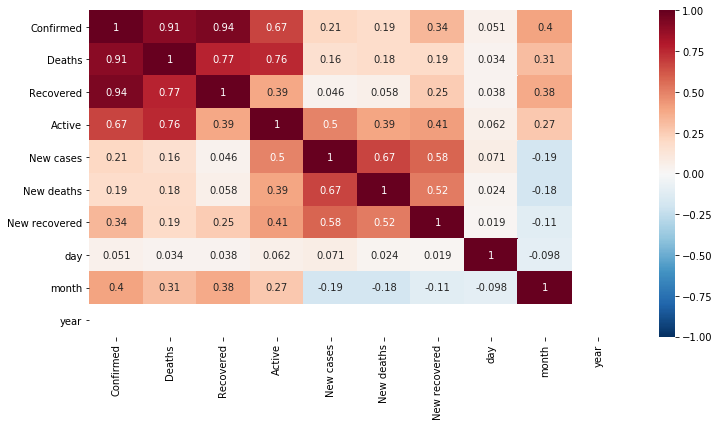

In [37]:
plt.figure(figsize=(12,6))
sns.heatmap(data_features.corr(), 
            vmin=-1.0,                       # Valor mínimo posible
            vmax=1.0,                        # Valor máximo posible
            annot=True,                     
            cmap="RdBu_r")                   
                                            
pass

Se observa que existe una correlación importante entre algunas de las variables. Destacamos que la variable 'Confirmed' tiene una correlación de 0,91 con la variable 'Deaths' y una correlación de 0.94 con la variable 'Recovered'. Si bien hay varias correlaciones relativamente altas, no se eliminirá ninguna de ellas, ya que con el número de variables que presenta el dataset no es del todo necesario. Además en este caso, la correlación de estas variables pueden demostrar el impacto que la enfermedad COVID-19 ha tenido en los países en cuanto a la relación de confirmados y muertes. De hecho, la primera conclusión que podemos sacar de esta matriz de correlaciones, es que hay una mayor correlación entre el número de confirmados y recuperados que entre el número de confirmados y muertes, de forma que hay un mayor porcentaje de recuperaciones frente a muertes.

En el scatter plot podemos visualizar la correlación existente entre las variables.

Text(0.5, 1.0, 'Correlación entre "Muertes" y "Confirmados"')

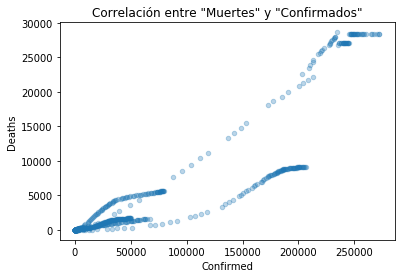

In [38]:
data_completed.plot(kind='scatter', x='Confirmed', y='Deaths', alpha=0.3)
plt.title('Correlación entre "Muertes" y "Confirmados"')

Text(0.5, 1.0, 'Correlación entre "Recuperados" y "Confirmados"')

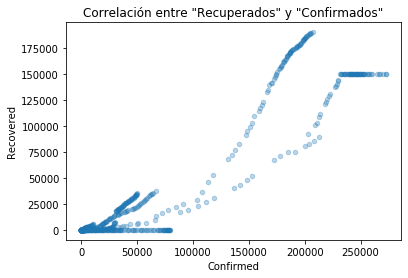

In [39]:
data_completed.plot(kind='scatter', x='Confirmed', y='Recovered', alpha=0.3)
plt.title('Correlación entre "Recuperados" y "Confirmados"')

### Visualización de datos

A continuación, dibujaremos la evolución temporal de cada una de las variables: valor de la bolsa, número de fallecidos, casos confirmados, población contagiada y población recuperada por Covid-19 en cada país. Así como la de la tasa de mortalidad.

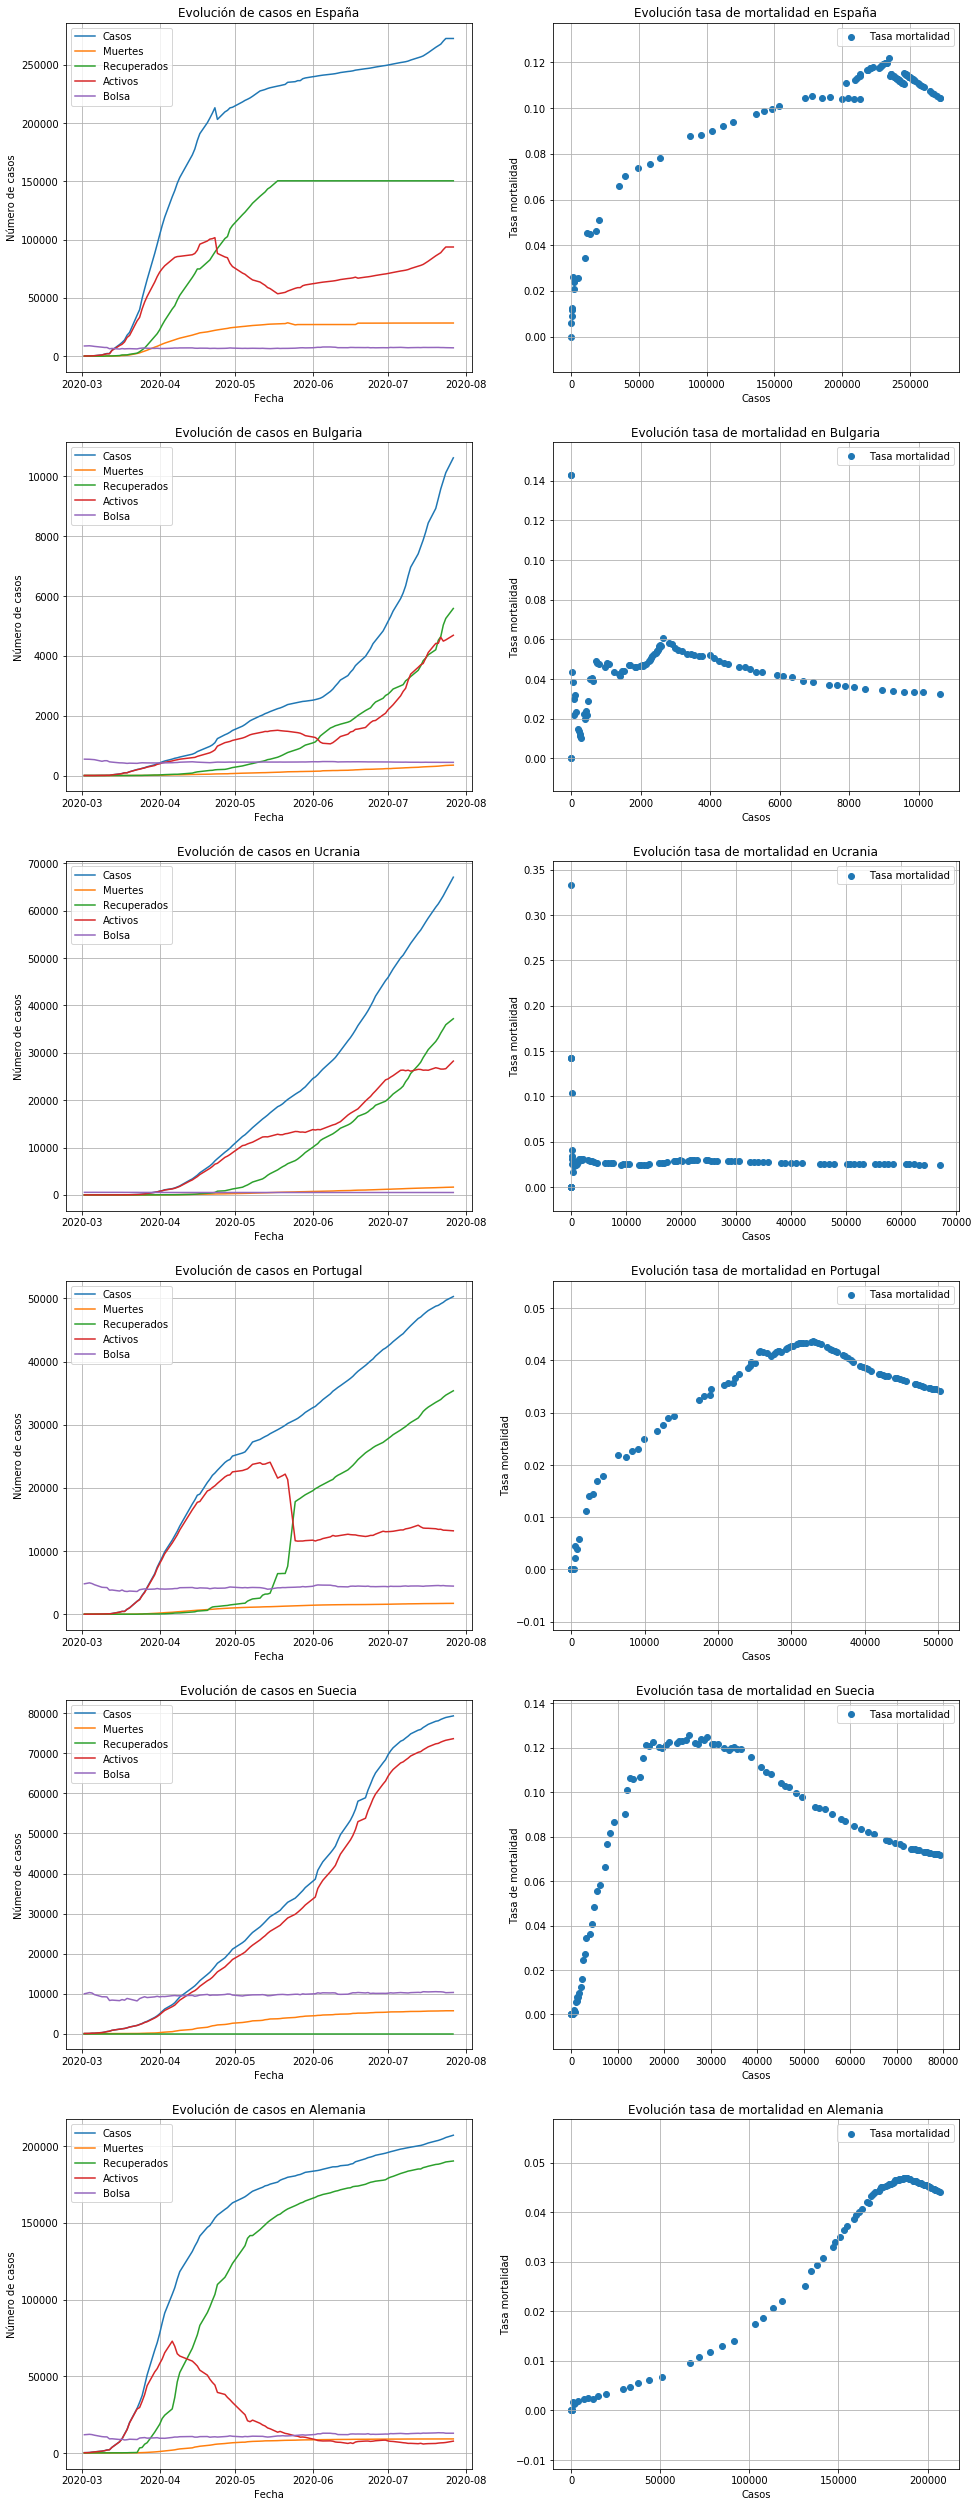

In [40]:
spain = data_completed[data_completed['Country/Region'] == 'Spain']
bulgaria = data_completed[data_completed['Country/Region'] == 'Bulgaria']
ukraine = data_completed[data_completed['Country/Region'] == 'Ukraine']
portugal = data_completed[data_completed['Country/Region'] == 'Portugal']
sweden = data_completed[data_completed['Country/Region'] == 'Sweden']
germany = data_completed[data_completed['Country/Region'] == 'Germany']

plt.figure(figsize=(16, 45)) # Se controla el tamaño del gráfico total

plt.subplot(6, 2, 1)
plt.plot(spain['Date'].values,spain['Confirmed'].values,label='Casos')
plt.plot(spain['Date'].values,spain['Deaths'].values,label='Muertes')
plt.plot(spain['Date'].values,spain['Recovered'].values,label='Recuperados')
plt.plot(spain['Date'].values,spain['Active'].values,label='Activos')
plt.plot(spain['Date'].values,spain['Bolsa'].values,label='Bolsa')
plt.ylabel('Número de casos')
plt.xlabel('Fecha')
plt.grid()
plt.legend()
plt.title('Evolución de casos en España')

#Tasa de mortalidad Muertes/casos como función del número de casos
plt.subplot(6, 2, 2)
spain['tasa_mortalidad']=spain['Deaths']/spain['Confirmed']
plt.scatter(spain['Confirmed'],spain['tasa_mortalidad'],label='Tasa mortalidad')
plt.ylabel('Tasa mortalidad')
plt.xlabel('Casos')
plt.grid()
plt.legend()
plt.title('Evolución tasa de mortalidad en España')
#plt.show()

plt.subplot(6, 2, 3) 
plt.plot(bulgaria['Date'].values,bulgaria['Confirmed'].values,label='Casos')
plt.plot(bulgaria['Date'].values,bulgaria['Deaths'].values,label='Muertes')
plt.plot(bulgaria['Date'].values,bulgaria['Recovered'].values,label='Recuperados')
plt.plot(bulgaria['Date'].values,bulgaria['Active'].values,label='Activos')
plt.plot(bulgaria['Date'].values,bulgaria['Bolsa'].values,label='Bolsa')
plt.ylabel('Número de casos')
plt.xlabel('Fecha')
plt.grid()
plt.legend()
plt.title('Evolución de casos en Bulgaria')
#plt.show()

plt.subplot(6, 2, 4)
bulgaria['tasa_mortalidad']=bulgaria['Deaths']/bulgaria['Confirmed']
plt.scatter(bulgaria['Confirmed'],bulgaria['tasa_mortalidad'],label='Tasa mortalidad')
plt.ylabel('Tasa mortalidad')
plt.xlabel('Casos')
plt.grid()
plt.legend()
plt.title('Evolución tasa de mortalidad en Bulgaria')
#plt.show()

plt.subplot(6, 2, 5)
plt.plot(ukraine['Date'].values,ukraine['Confirmed'].values,label='Casos')
plt.plot(ukraine['Date'].values,ukraine['Deaths'].values,label='Muertes')
plt.plot(ukraine['Date'].values,ukraine['Recovered'].values,label='Recuperados')
plt.plot(ukraine['Date'].values,ukraine['Active'].values,label='Activos')
plt.plot(ukraine['Date'].values,ukraine['Bolsa'].values,label='Bolsa')
plt.ylabel('Número de casos')
plt.xlabel('Fecha')
plt.grid()
plt.legend()
plt.title('Evolución de casos en Ucrania')
#plt.show()

plt.subplot(6, 2, 6)
ukraine['tasa_mortalidad']=ukraine['Deaths']/ukraine['Confirmed']
plt.scatter(ukraine['Confirmed'],ukraine['tasa_mortalidad'],label='Tasa mortalidad')
plt.ylabel('Tasa mortalidad')
plt.xlabel('Casos')
plt.grid()
plt.legend()
plt.title('Evolución tasa de mortalidad en Ucrania')
#plt.show()

plt.subplot(6, 2, 7)
plt.plot(portugal['Date'].values,portugal['Confirmed'].values,label='Casos')
plt.plot(portugal['Date'].values,portugal['Deaths'].values,label='Muertes')
plt.plot(portugal['Date'].values,portugal['Recovered'].values,label='Recuperados')
plt.plot(portugal['Date'].values,portugal['Active'].values,label='Activos')
plt.plot(portugal['Date'].values,portugal['Bolsa'].values,label='Bolsa')
plt.ylabel('Número de casos')
plt.xlabel('Fecha')
plt.grid()
plt.legend()
plt.title('Evolución de casos en Portugal')
#plt.show()

plt.subplot(6, 2, 8)
portugal['tasa_mortalidad']=portugal['Deaths']/portugal['Confirmed']
plt.scatter(portugal['Confirmed'],portugal['tasa_mortalidad'],label='Tasa mortalidad')
plt.ylabel('Tasa mortalidad')
plt.xlabel('Casos')
plt.grid()
plt.legend()
plt.title('Evolución tasa de mortalidad en Portugal')
#plt.show()

plt.subplot(6, 2, 9)
plt.plot(sweden['Date'].values,sweden['Confirmed'].values,label='Casos')
plt.plot(sweden['Date'].values,sweden['Deaths'].values,label='Muertes')
plt.plot(sweden['Date'].values,sweden['Recovered'].values,label='Recuperados')
plt.plot(sweden['Date'].values,sweden['Active'].values,label='Activos')
plt.plot(sweden['Date'].values,sweden['Bolsa'].values,label='Bolsa')
plt.ylabel('Número de casos')
plt.xlabel('Fecha')
plt.grid()
plt.legend()
plt.title('Evolución de casos en Suecia')
#plt.show()

plt.subplot(6, 2, 10)
sweden['tasa_mortalidad']=sweden['Deaths']/sweden['Confirmed']
plt.scatter(sweden['Confirmed'],sweden['tasa_mortalidad'],label='Tasa mortalidad')
plt.ylabel('Tasa de mortalidad')
plt.xlabel('Casos')
plt.grid()
plt.legend()
plt.title('Evolución tasa de mortalidad en Suecia')
#plt.show()

plt.subplot(6, 2, 11)
plt.plot(germany['Date'].values,germany['Confirmed'].values,label='Casos')
plt.plot(germany['Date'].values,germany['Deaths'].values,label='Muertes')
plt.plot(germany['Date'].values,germany['Recovered'].values,label='Recuperados')
plt.plot(germany['Date'].values,germany['Active'].values,label='Activos')
plt.plot(germany['Date'].values,germany['Bolsa'].values,label='Bolsa')
plt.ylabel('Número de casos')
plt.xlabel('Fecha')
plt.grid()
plt.legend()
plt.title('Evolución de casos en Alemania')
#plt.show()

plt.subplot(6, 2, 12)
germany['tasa_mortalidad']=germany['Deaths']/germany['Confirmed']
plt.scatter(germany['Confirmed'],germany['tasa_mortalidad'],label='Tasa mortalidad')
plt.ylabel('Tasa mortalidad')
plt.xlabel('Casos')
plt.grid()
plt.legend()
plt.title('Evolución tasa de mortalidad en Alemania')
plt.show()

Algunas de las conclusiones que podemos sacar son que: (i) el mayor número de muertes lo alcanzó España, (ii) tanto Bulgaria como Ucrania muestran un crecimiento de contagios exponencial, lo que puede traducirse en una toma de medidas sanitarias más tardías que en los demás países. También podemos observar que la tasa de mortalidad se dispara con el número de casos confirmados, especialmente en el caso de España y Alemania. Sin embargo, la mayor tasa de mortalidad la alcanza Suecia, seguida de España, y el país con menos tasa de mortalidad de nuestro estudio es Ucrania, el cual se mantiene más o menos constante.

Pintamos ahora dos gráficos de barras: (i) número de muertes y casos confirmados por país, y (ii) media de muertes y casos confirmados por mes (englobando a todos los países)

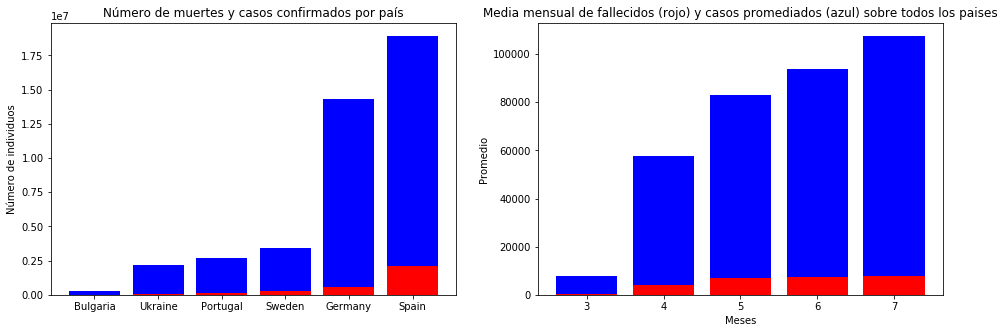

In [41]:
#AGRUPAMOS PRIMERO POR PAIS
data_pais=data_completed.groupby(by='Country/Region').sum()
paises_casos=data_pais.sort_values(by='Confirmed')
paises_muertes=data_pais.sort_values(by='Deaths')
data_mean = data_completed.groupby('month', as_index = False).mean()
#Dibujamos los gráficos de barras
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.ylabel('Número de individuos')
plt.title('Número de muertes y casos confirmados por país')
#plt.xticks(rotation='vertical')
plt.bar(paises_casos.index,paises_casos.Confirmed, color = "b")
plt.bar(paises_muertes.index,paises_muertes.Deaths, color = "r")

plt.subplot(1,2,2)
plt.bar(data_mean.month,data_mean.Confirmed, color = "b")
plt.bar(data_mean.month,data_mean.Deaths, color = "r")
plt.title('Media mensual de fallecidos (rojo) y casos promediados (azul) sobre todos los paises')
plt.xlabel('Meses')
plt.ylabel('Promedio')
plt.show()

In [42]:
data_pais

,Bolsa,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,day,month,year
Country/Region,,,,,,,,,,,
Bulgaria,44101.24,279677,12046,126403,141228,8074,262,4688,1519,490,197960
Germany,1149396.66,14345247,597619,11733679,2013949,148646,6999,144498,1589,505,206040
Portugal,439744.59,2672157,101986,1275254,1294917,33986,1150,18512,1590,511,208060
Spain,733769.20,18918521,2093793,10481605,6343123,204597,19709,101444,1590,511,208060
Sweden,981264.18,3407002,305646,0,3101356,63049,4949,0,1568,500,204020
Ukraine,48993.41,2159134,57361,934521,1167252,44304,1127,27442,1501,486,195940


Si lo que queremos es observar una distribución de probabilidad de la bolsa de valores por país, tenemos lo siguiente:

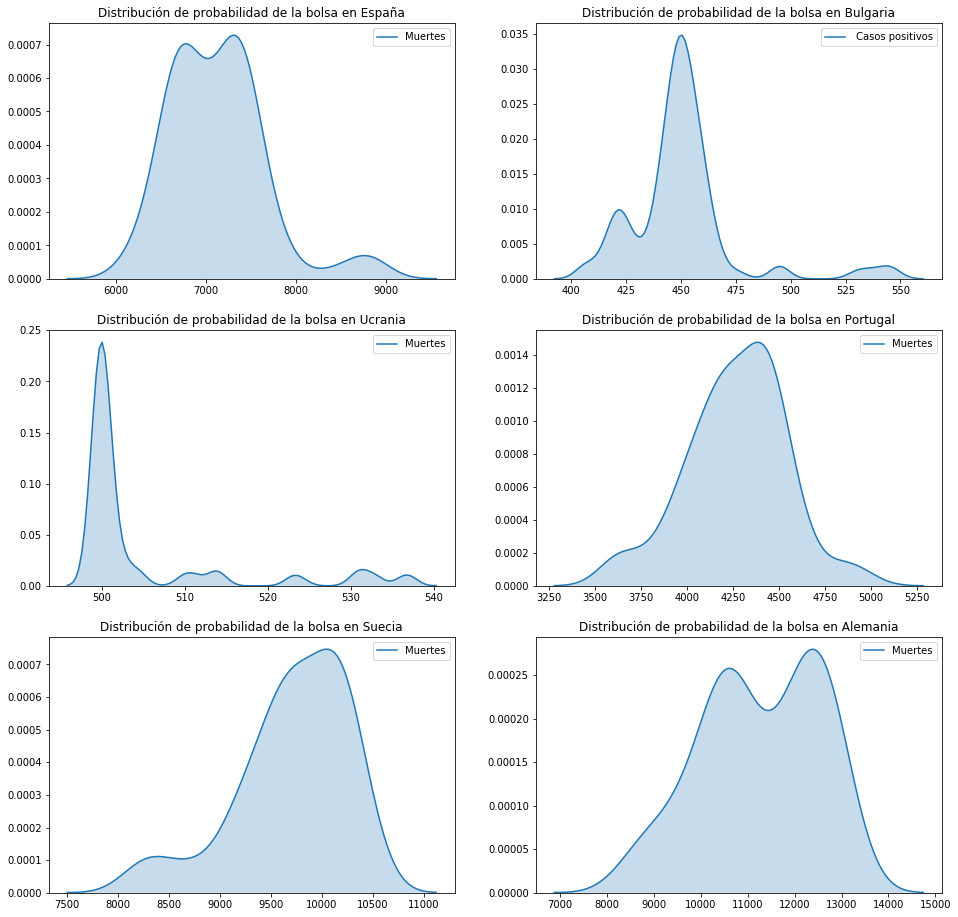

In [43]:
#DISTRICUCIÓN DE PROBABILIDAD
plt.figure(figsize=(16, 16))

plt.subplot(3, 2, 1)
sns.kdeplot(spain['Bolsa'],shade=True,label='Muertes')
plt.title('Distribución de probabilidad de la bolsa en España')

plt.subplot(3, 2, 2)
sns.kdeplot(bulgaria['Bolsa'],shade=True,label=' Casos positivos')
plt.title('Distribución de probabilidad de la bolsa en Bulgaria')

plt.subplot(3, 2, 3)
sns.kdeplot(ukraine['Bolsa'],shade=True,label='Muertes')
plt.title('Distribución de probabilidad de la bolsa en Ucrania')

plt.subplot(3, 2, 4)
sns.kdeplot(portugal['Bolsa'],shade=True,label='Muertes')
plt.title('Distribución de probabilidad de la bolsa en Portugal')

plt.subplot(3, 2, 5)
sns.kdeplot(sweden['Bolsa'],shade=True,label='Muertes')
plt.title('Distribución de probabilidad de la bolsa en Suecia')

plt.subplot(3, 2, 6)
sns.kdeplot(germany['Bolsa'],shade=True,label='Muertes')
plt.title('Distribución de probabilidad de la bolsa en Alemania')
plt.show()

Ahora, compararemos distribuciones de pares de variables.

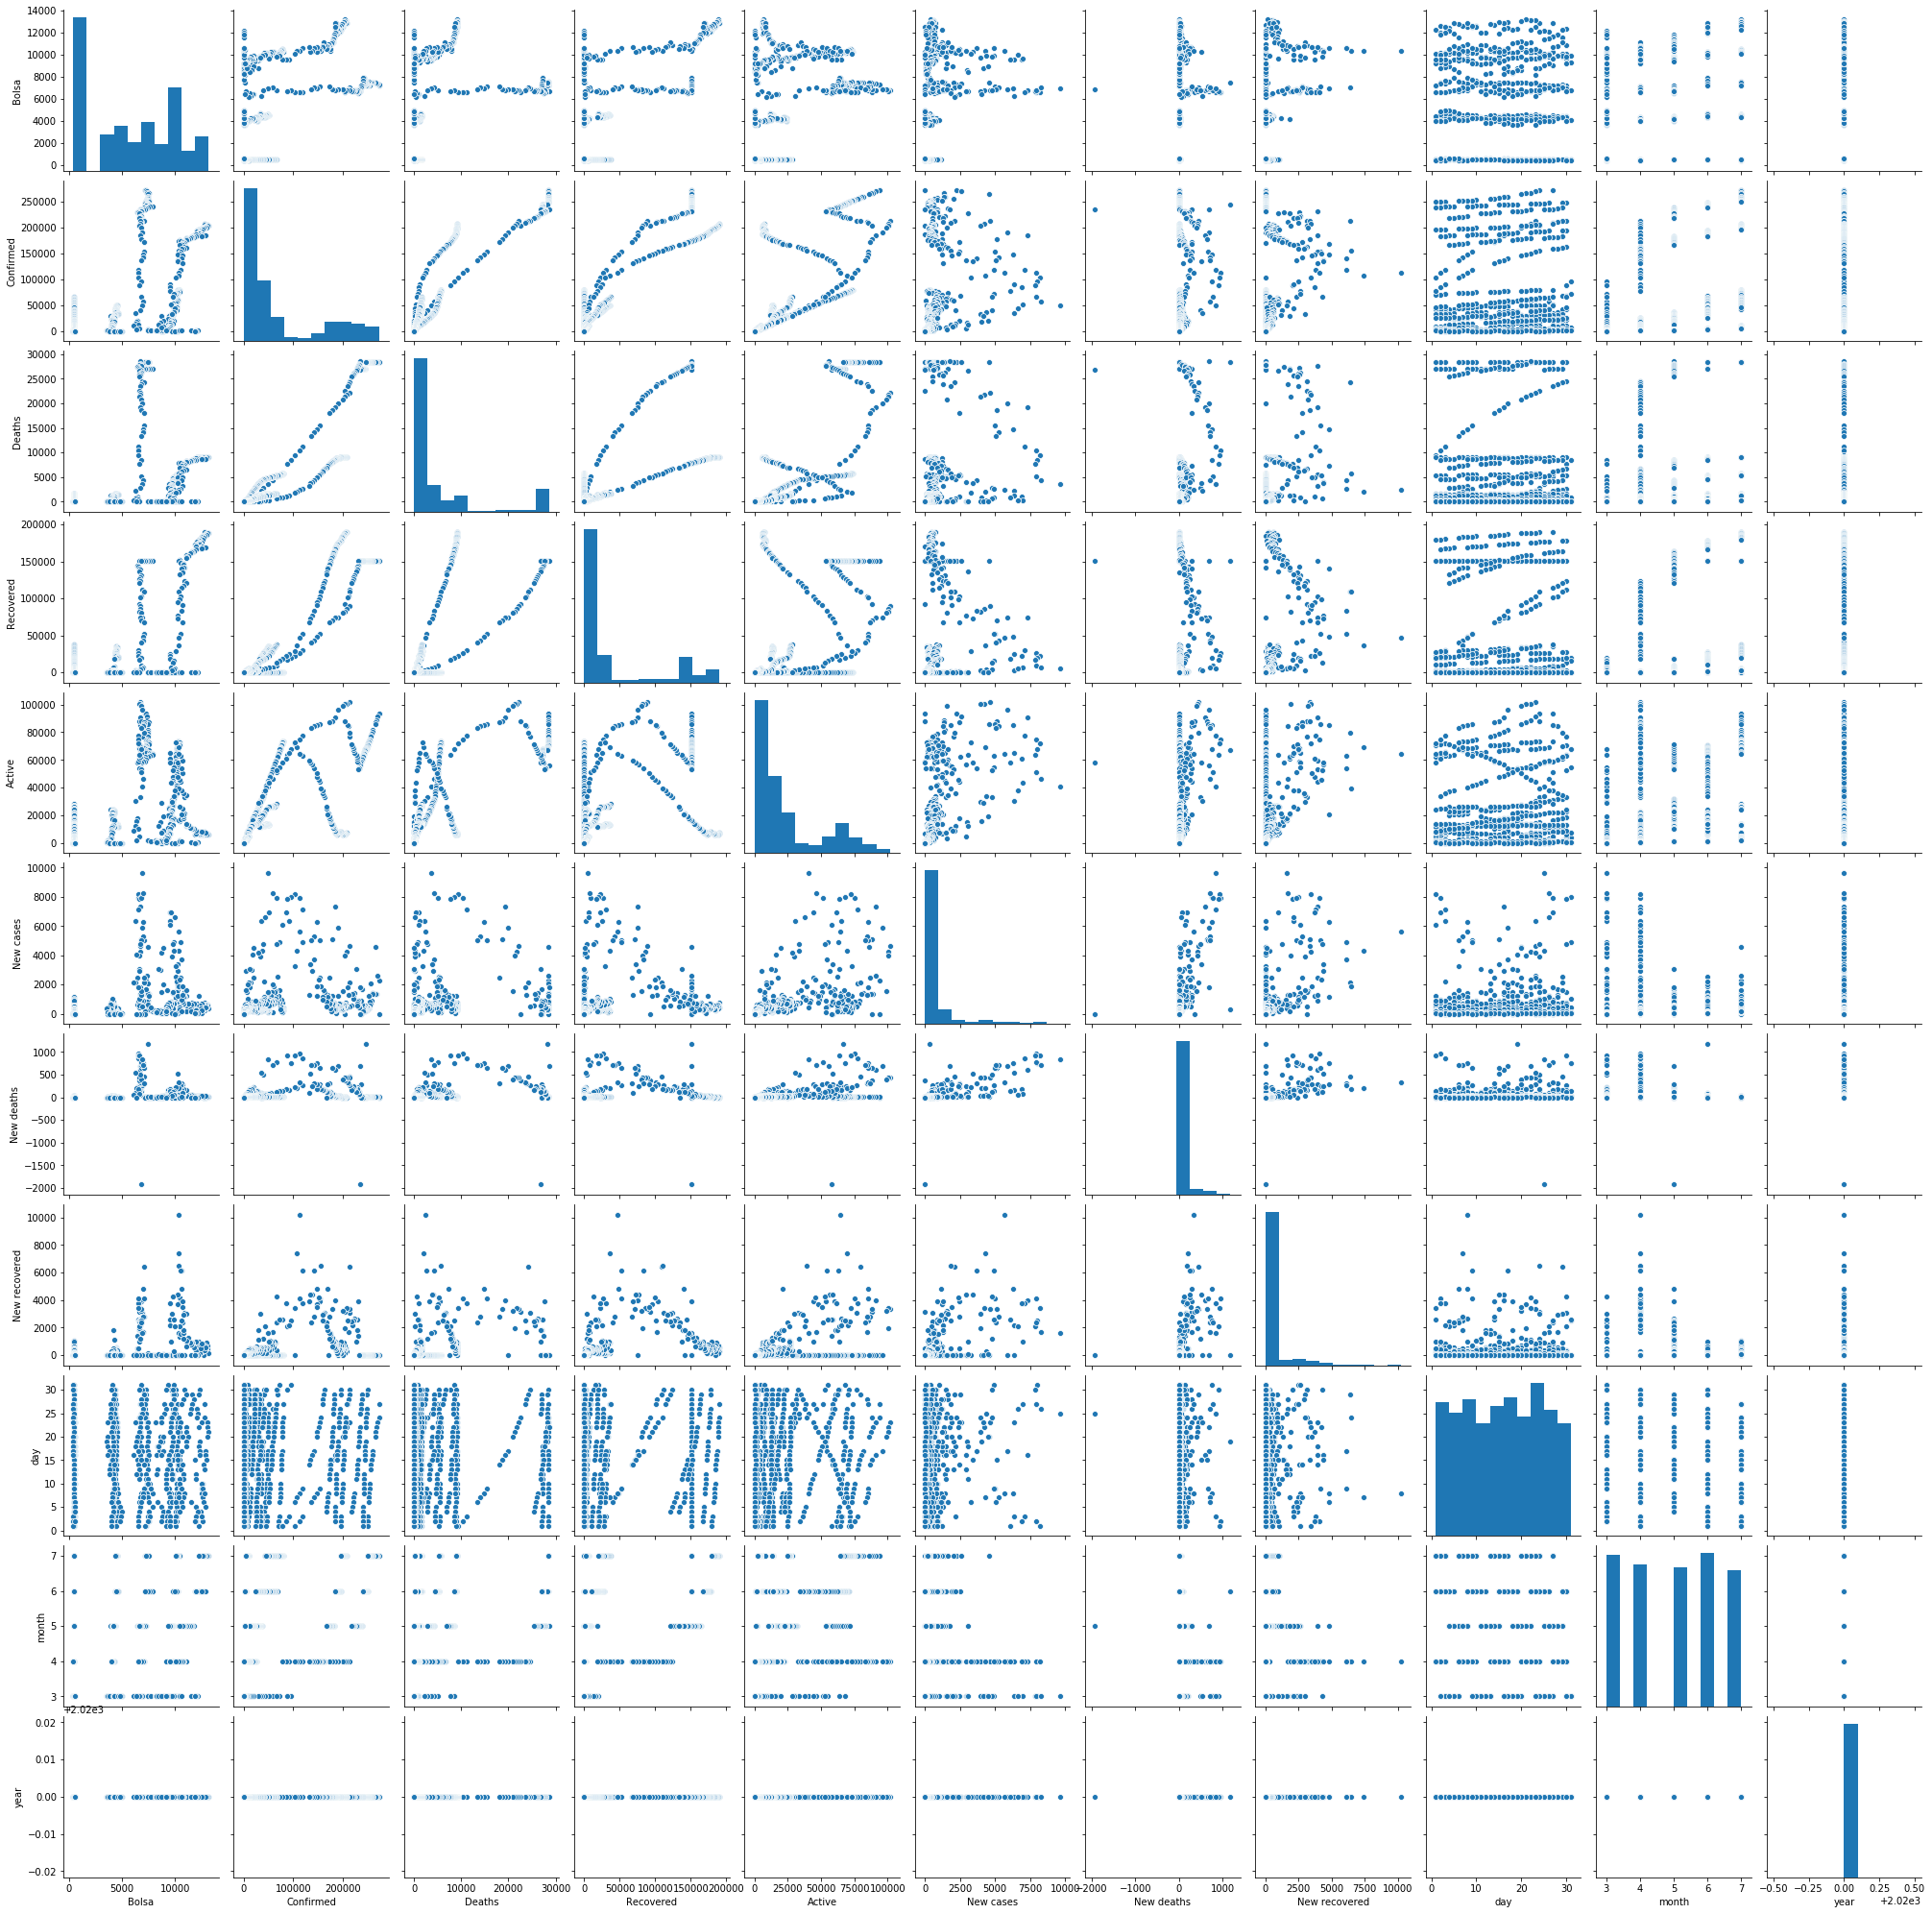

In [44]:
sns.pairplot(data_completed)

### Separación en train y test

Eliminamos la variable Date, ya que hemos extraido el dia, mes y año. Nuestro modelo de regresión funcionará mejor tras haber convertido la variabe en Date en una variable numérica.
Hacemos lo mismo con la variable Country.

In [45]:
#del data_completed['Date']
#del data_completed['Country/Region']

En predicciones de la bolsa de valores, es importante que no elijamos los datos de train y test aleatoriamente. En este caso, tendremos que usar los datos más recientes para el conjunto de test ya que proporcionará unos mejores resultados para nuestras predicciones.

In [46]:
data_completed_new = data_completed.copy()

In [47]:
#del data_completed_new['Bolsa']

In [48]:
#X_data = data_completed_new
#Y_data = data_completed['Bolsa']

El conjunto de test ya está separado, y no vamos a tocarlo ya hasta el final. Solo trabajamos con el conjunto de train (del cual iremos sacando folds de validación cruzada cuando hagamos Grid Search).
Pero antes de hacer los modelos y validaciones cruzadas, deberíamos plantear, una serie de decisiones sobre nuestros datos:

¿Descartar/ seleccionar variables?

¿Quitar outliers?

¿Estandarizar las features?

Al hacer validación (cross validation), así como Grid Search, es recomendable aplicar estos pre-procesados exclusivamente sobre los conjuntos de train, y no sobre los de validación. 
Los modelos, así como todos los posibles pre-procesados que les acompañan, solo deben ser entrenados sobre el conjunto de train, con el que el modelo entrena. Si no lo hacemos así, filtramos información a los modelos más allá de la de los datos con los que entrenan, y esto ocasiona sobreajuste.

La respuesta a la primera pregunta sobre el descarte/ selección de variables es que no sería necesario. Esencialmente todos los modelos tanto de clasificación como de regresión modernos pueden lidiar con unas cuantas decenas de features sin que resulte un problema. 

Con respecto a la segunda pregunta sobre el preprocesamiento de outliers, dado que el problema que se analiza parte de una situación extraordinaria en la economía, sería posible encontrar outliers en aquellos puntos más críticos de la pandemia. Sin embargo, estos outliers son necesarios para el completo análisis y entendimiento de los datos, con el fin de entender la magnitud del impacto que este suceso ha tenido en la economía. Prescindir de estos datos, sería perder fiabilidad en nuestro análisis.

La estandarización de features será necesario para que el modelo puedo tratar las variables de forma homogénea y no darle mayor peso a aquellas features aparentemente más grandes debido a diferentes magnitudes, unidades y rango. En todos los modelos de sklearn debemos estandarizar las features excepto en los árboles de decisión.

In [49]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_completed_new,
                               train_size=0.75,
                               test_size=0.25)

In [50]:
Y_train = train['Bolsa']

In [51]:
Y_test= test['Bolsa']

Eliminamos la variable Bolsa del conjunto de train y test

In [52]:
del train['Bolsa']
del test['Bolsa']

Tras la separación del dataset en el conjunto de tren y de test comenzaremos a aplicar los modelos de machine learning a los conjuntos de datos.
El primer modelo elegido será un modelo ARIMA, seguido de un arbol de decisión y una red neuronal recurrente.
En general, si el modelo a tratar es uno basado en árboles podemos ahorrar la parte de pre-procesado de selección de variables ya que los árboles son capaces de seleccionar bien por motu propio.

## Modelo ARIMA

### España

In [53]:
data_spain = data_completed_new[data_completed_new['Country/Region'] == 'Spain']
del data_spain['Country/Region']

In [54]:
#data_spain_seasonal['Date'] = pd.to_datetime(data_spain_seasonal['Date'], format="%d.%m.%Y")
#data_spain['Date'] = pd.to_datetime(data_spain['Date'], format="%d.%m.%Y")

In [55]:
data_spain= data_spain['Bolsa']

In [56]:
data_spain=data_spain[::-1]


data_spain=pd.DataFrame(data_spain)
data_spain.reset_index(inplace=True)
del data_spain['index']
data_spain

,Bolsa
0,8741.5
1,8811.6
2,8910.0
3,8683.0
4,8375.6
...,...
98,7494.5
99,7390.1
100,7384.9
101,7294.7


In [57]:
#data_spain_seasonal= data_spain_seasonal[['Date', 'Bolsa']]
data_spain= data_spain['Bolsa']

In [58]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import acf
import pmdarima as pm

Antes de construir el modelo ARIMA, miramos si la serie temporal es estacionaria

In [59]:
result = adfuller(data_spain)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.270302
p-value: 0.016259


El p-value para la serie temporal que representa los valores de la bolsa para españa presenta un valor de 0.01. Calculamos la diferencia de la serie y miramos elgráfico de autocorrelación.

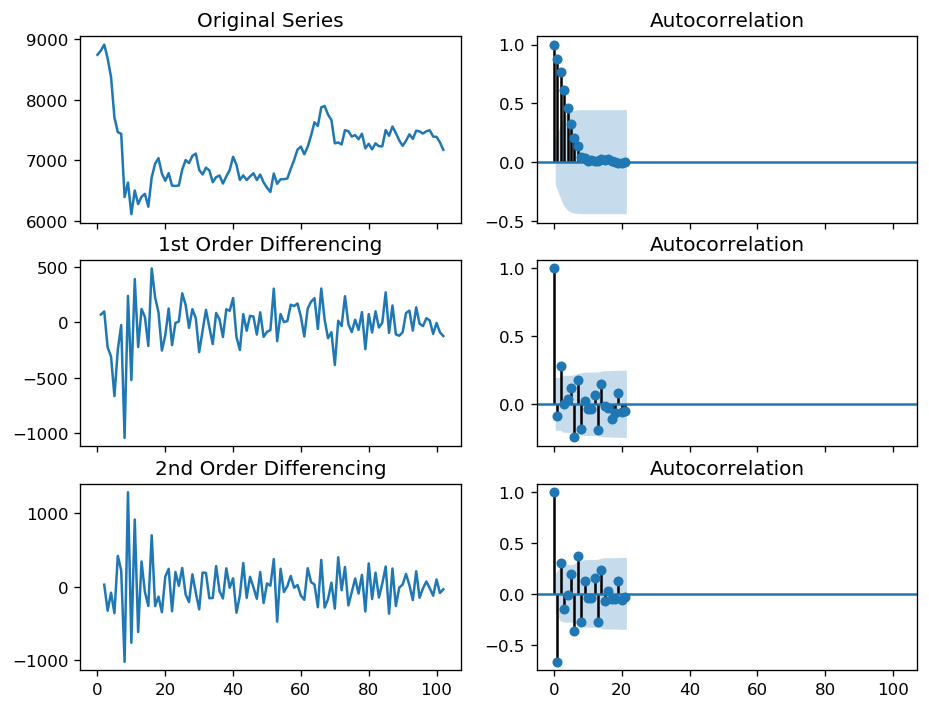

In [60]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_spain); axes[0, 0].set_title('Original Series')
plot_acf(data_spain, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_spain.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_spain.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_spain.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_spain.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


Para la serie anterior, con un p-value = 0.01 se considera que la serie ya es estacionaria de forma que no necesitaría realizar una diferenciación. Sin embargo al obserar el gráfico para el primer orden de diferenciación podemos ver que la serie temporal cuenta con un lag prominente mientras que el reso de lags se encuentran dentro de la zona límite. Con el objetivo de contrastar resultados del modelo se analizará la serie temporal con d=0 y d=1 para . Al mirar el gráfico de autocorrelación para la segunda diferenciación, el retraso entra en la zona negativa lejana bastante rápido, lo que indica que la serie podría haber sido sobrediferenciada si usamos dos diferenciaciones.
Con el objetivo de apoyar los resultados se ha realizado el test de Dickey fuller que arroja un resultado de d=0 para la serie temporal, de forma que la serie es estacionaria.


In [61]:
## Adf Test
ndiffs(data_spain, test='adf')

0

#### AR term(p)

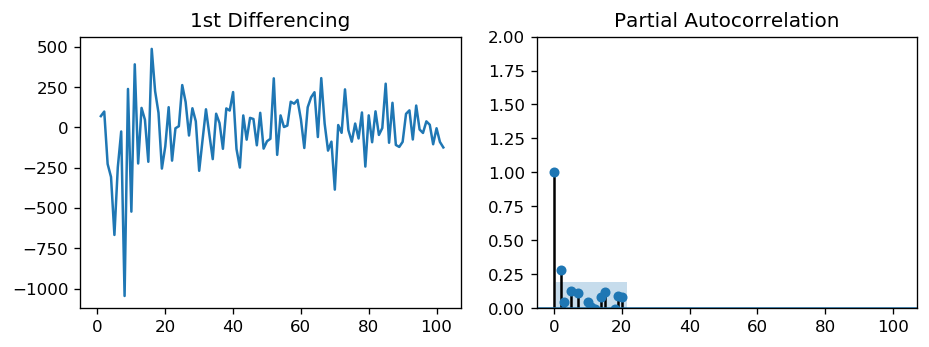

In [62]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data_spain.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,2))
plot_pacf(data_spain.diff().dropna(), ax=axes[1])

plt.show()

Puede observar que el retraso PACF 1 es bastante significativo ya que está muy por encima de la línea de importancia. El retardo 2 también resulta significativo, logrando cruzar levemente el límite de significancia (región azul). Pero voy a ser conservador y tentativamente fijaré la p como 1.

#### MA term (q)

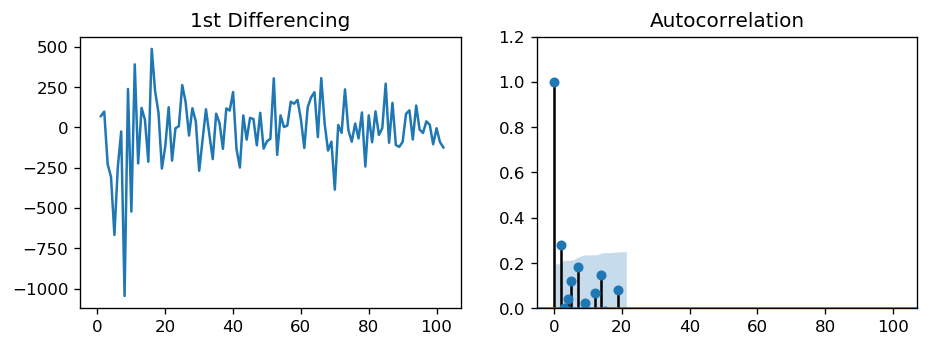

In [63]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data_spain.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data_spain.diff().dropna(), ax=axes[1])

plt.show()

En este caso, un retraso está muy por encima de la linea de importancia. De manera que se fijará q=1.

#### ARIMA model

In [64]:
# 1,1,1 ARIMA(p,d,q) Model d=0, p=1, q=1
model = ARIMA(data_spain, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Bolsa   No. Observations:                  103
Model:                     ARMA(1, 1)   Log Likelihood                -694.251
Method:                       css-mle   S.D. of innovations            202.299
Date:                Sun, 05 Dec 2021   AIC                           1396.502
Time:                        13:02:16   BIC                           1407.041
Sample:                             0   HQIC                          1400.770
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7370.9956    393.283     18.742      0.000    6600.174    8141.817
ar.L1.Bolsa     0.9560      0.034     28.523      0.000       0.890       1.022
ma.L1.Bolsa    -0.0312      0.082     -0.382    

In [65]:
# 1,1,1 ARIMA(p,d,q) Model d=1, p=1, q=1
model = ARIMA(data_spain, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Bolsa   No. Observations:                  102
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -685.643
Method:                       css-mle   S.D. of innovations            200.915
Date:                Sun, 05 Dec 2021   AIC                           1379.286
Time:                        13:02:16   BIC                           1389.786
Sample:                             1   HQIC                          1383.537
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -15.3471     18.237     -0.842      0.400     -51.091      20.396
ar.L1.D.Bolsa    -0.5928      0.207     -2.868      0.004      -0.998      -0.188
ma.L1.D.Bolsa     0.4594      0.215     

El p value de los parámetros AR(1) y MA(1) son significativos ya que su p-values es menor a 0.05. Vemos que el modelo ARIMA(1,1,1) arroja mejores resultados presentando un valor de la métrica AIC que se reduce de 1396 a 1379 cuando aplicamos una diferenciación de 1, en lugar de 0 diferenciaciones. 

#### Residuos

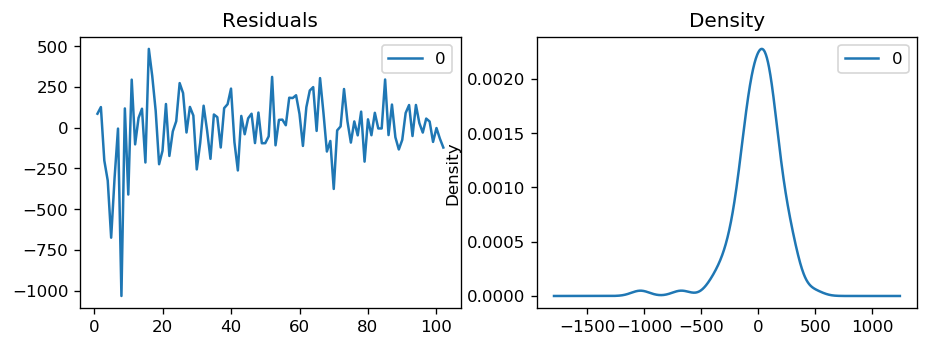

In [66]:
#Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen estar bien con una media cercana a cero y una varianza uniforme. Grafiquemos los datos reales frente a los valores ajustados.

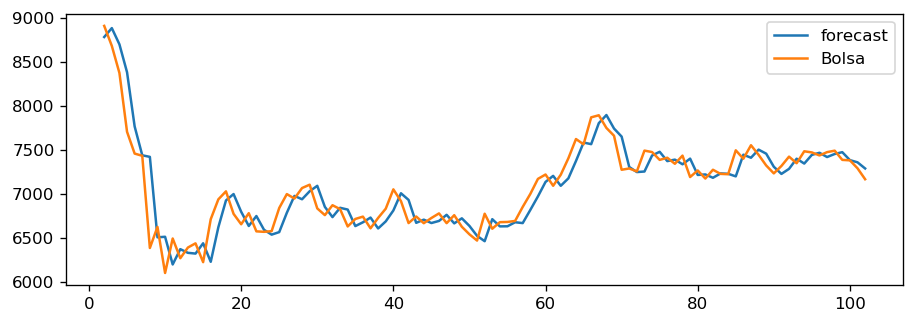

In [67]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

#### Out-of-Time Cross validation

In [68]:
# Create Training and Test
train = data_spain[:76]
test = data_spain[76:]

                              ARMA Model Results                              
Dep. Variable:                  Bolsa   No. Observations:                   76
Model:                     ARMA(1, 1)   Log Likelihood                -521.296
Method:                       css-mle   S.D. of innovations            226.866
Date:                Sun, 05 Dec 2021   AIC                           1050.593
Time:                        13:02:17   BIC                           1059.916
Sample:                             0   HQIC                          1054.319
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7411.8881    505.893     14.651      0.000    6420.357    8403.420
ar.L1.Bolsa     0.9557      0.037     25.821      0.000       0.883       1.028
ma.L1.Bolsa    -0.0180      0.095     -0.190    

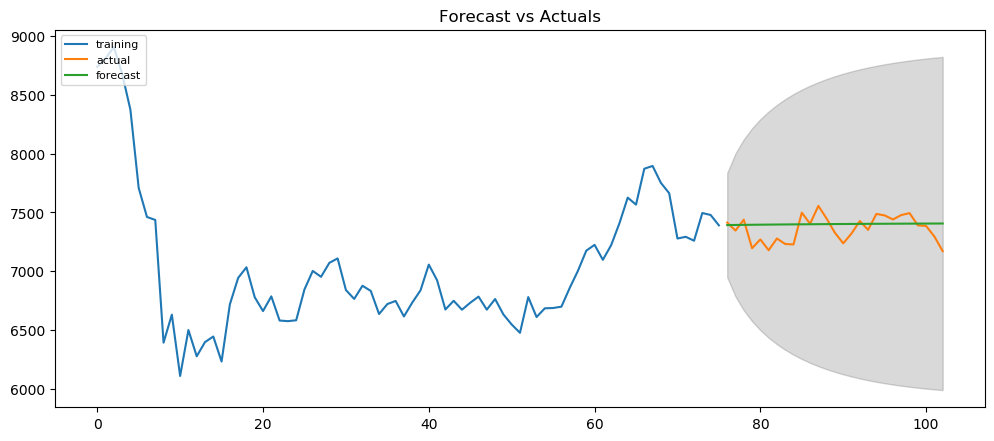

In [69]:
# Build Model

model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(27, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

A partir del gráfico, el modelo ARIMA (1,1,1) parece dar un pronóstico direccionalmente correcto. Y los valores reales observados se encuentran dentro de la banda de confianza del 95%. Eso parece estar bien.

Pero cada uno de los pronósticos previstos está consistentemente por debajo de los reales. Eso significa que, al agregar una pequeña constante a nuestro pronóstico, la precisión ciertamente mejorará. Por lo tanto, definitivamente hay margen de mejora.

Entonces, lo que voy a hacer es aumentar el orden de diferenciación a dos, es decir, establecer d = 2 y aumentar iterativamente p hasta 5 y luego q hasta 5 para ver qué modelo da menos AIC y también buscar un gráfico que ofrece datos reales y pronósticos más cercanos.

Mientras hago esto, vigilo los valores P de los términos AR y MA en el resumen del modelo. Deben estar tan cerca de cero, idealmente, menos de 0.05. El término MA presenta un p-value de 0.85, de forma que no es significativo pues su valor deberia ser menor a 0.05

                             ARIMA Model Results                              
Dep. Variable:                D.Bolsa   No. Observations:                   75
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -512.933
Method:                       css-mle   S.D. of innovations            225.874
Date:                Sun, 05 Dec 2021   AIC                           1033.866
Time:                        13:02:17   BIC                           1043.136
Sample:                             1   HQIC                          1037.567
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -18.0105     24.158     -0.746      0.456     -65.360      29.339
ar.L1.D.Bolsa    -0.5995      0.256     -2.340      0.019      -1.102      -0.097
ma.L1.D.Bolsa     0.4806      0.267     

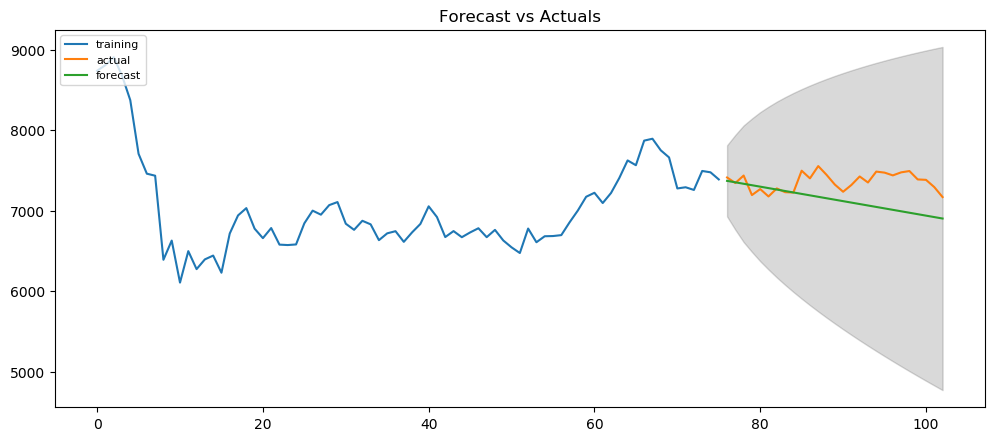

In [70]:
# Build Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(27, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

El valor de AIC mejora en el segundo modelo, así como el valor de p-value del componente MA que es ligeramente superior al valor de 0.05.

In [71]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE        
    corr = np.corrcoef(forecast, actual)[0,1]   
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 
             'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.0329810234150899,
 'acf1': 0.8265078312233486,
 'corr': -0.20587075282430736,
 'minmax': 0.03296198830214081}

AUTO ARIMA 

In [72]:
model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stationary= False,
                      stepwise=True)
model.fit(train)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1564.825, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1054.678, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1051.170, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1053.009, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1053.217, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1047.559, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1091.813, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1050.631, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1048.990, Time=0.19 s

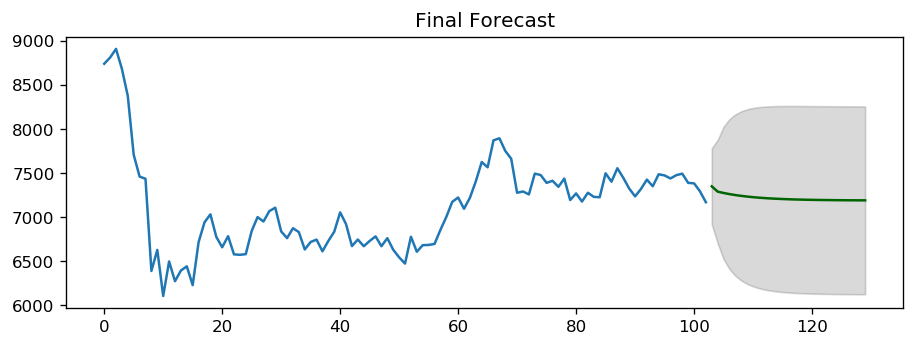

In [83]:
# Forecast
n_periods = 22
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(data_spain), len(data_spain)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data_spain)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

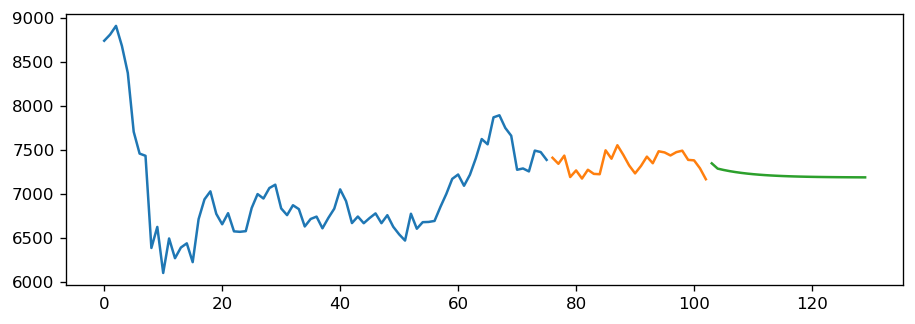

In [84]:
#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(test, label='Valid')
plt.plot(fc_series, label='Prediction')
plt.show()

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

## Escenarios

# Bulgaria

In [86]:
data_bulgaria = data_completed_new[data_completed_new['Country/Region'] == 'Bulgaria']
del data_bulgaria['Country/Region']

In [87]:
data_bulgaria= data_bulgaria['Bolsa']

In [88]:
data_bulgaria=data_bulgaria[::-1]


data_bulgaria=pd.DataFrame(data_bulgaria)
data_bulgaria.reset_index(inplace=True)
del data_bulgaria['index']


In [89]:
data_bulgaria= data_bulgaria['Bolsa']

#### Estacionariedad

In [90]:
result = adfuller(data_bulgaria)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.027353
p-value: 0.032418


El p-value para la serie temporal que representa los valores de la bolsa para españa presenta un valor de 0.03. Calculamos la diferencia de la serie y miramos elgráfico de autocorrelación. observamos los gráficos de autocorrelación vemos como el gráfico de autocorrelación para le primer orden de diferenciación tiene un retraso muy elevado, por lo tanto podriamos esperar que el valor optimo de d para esta serie temporal sea de una diferenciación.

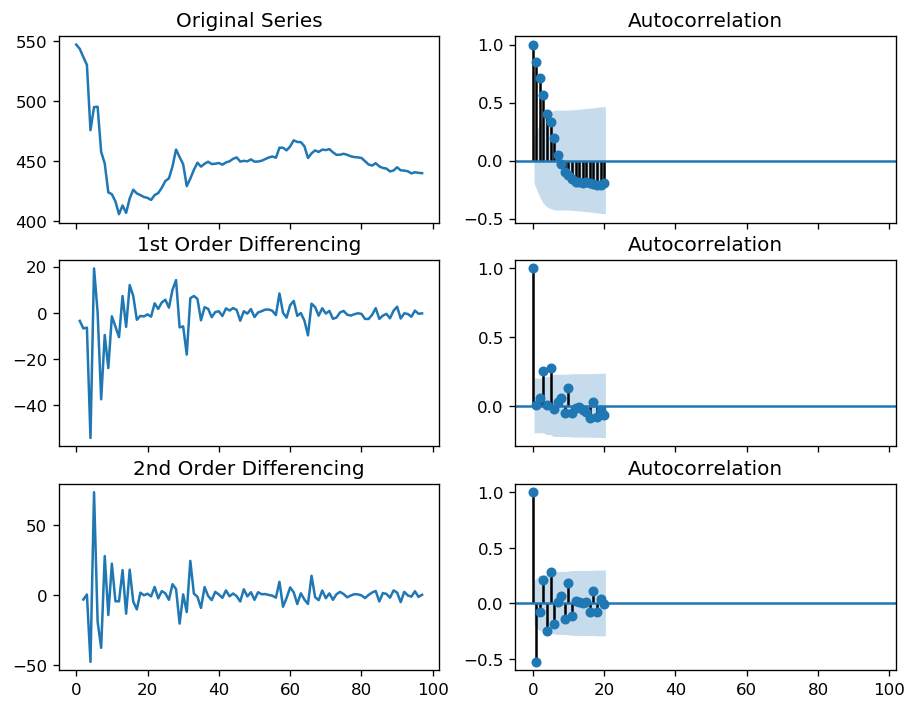

In [91]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_bulgaria); axes[0, 0].set_title('Original Series')
plot_acf(data_bulgaria, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_bulgaria.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_bulgaria.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_bulgaria.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_bulgaria.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Para la serie anterior, con un p-value = 0.03 se considera que la serie ya es estacionaria de forma que no necesitaría realizar una diferenciación. Sin embargo al obserar el gráfico para el primer orden de diferenciación podemos ver que la serie temporal cuenta con un lag prominente mientras que el reso de lags se encuentran dentro de la zona límite. Con el objetivo de contrastar resultados del modelo se analizará la serie temporal con d=0 y d=1 para . Al mirar el gráfico de autocorrelación para la segunda diferenciación, el retraso entra en la zona negativa lejana bastante rápido, lo que indica que la serie podría haber sido sobrediferenciada si usamos dos diferenciaciones. Con el objetivo de apoyar los resultados se ha realizado el test de Dickey fuller que arroja un resultado de d=0 para la serie temporal, de forma que la serie es estacionaria.

In [ ]:
## Adf Test
ndiffs(data_bulgaria, test='adf')

In [92]:
# Create Training and Test
train_bulgaria = data_bulgaria[:76]
test_bulgaria = data_bulgaria[76:]

## Auto-ARIMA

In [97]:
model_bulgaria = pm.auto_arima(train_bulgaria, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stationary= False,
                      stepwise=True)


print(model_bulgaria.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=552.478, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=602.062, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=580.359, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=552.155, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=600.064, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=551.652, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=552.619, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=550.447, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=551.153, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=551.320, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=551.365, Time=0.03 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.18 se

El modelo que mejor se ajusta a los datos y que consigue una mayor minimización de la métrica AIC es el modelo ARIMA(0,2,2). Puede observarse en el ANEXO X como el p-valor de los componentes MA(p) es 0, lo que indica que el modelo se ajusta a los datos.

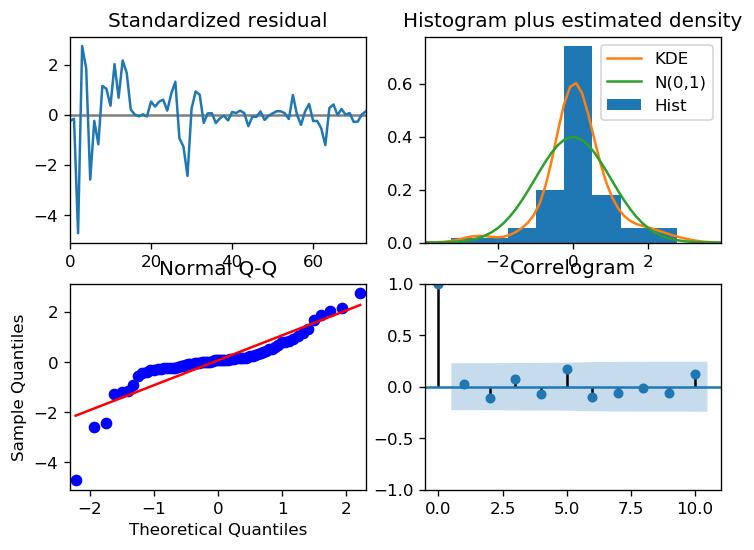

In [98]:
model_bulgaria.plot_diagnostics(figsize=(7,5))
plt.show()

Forecast

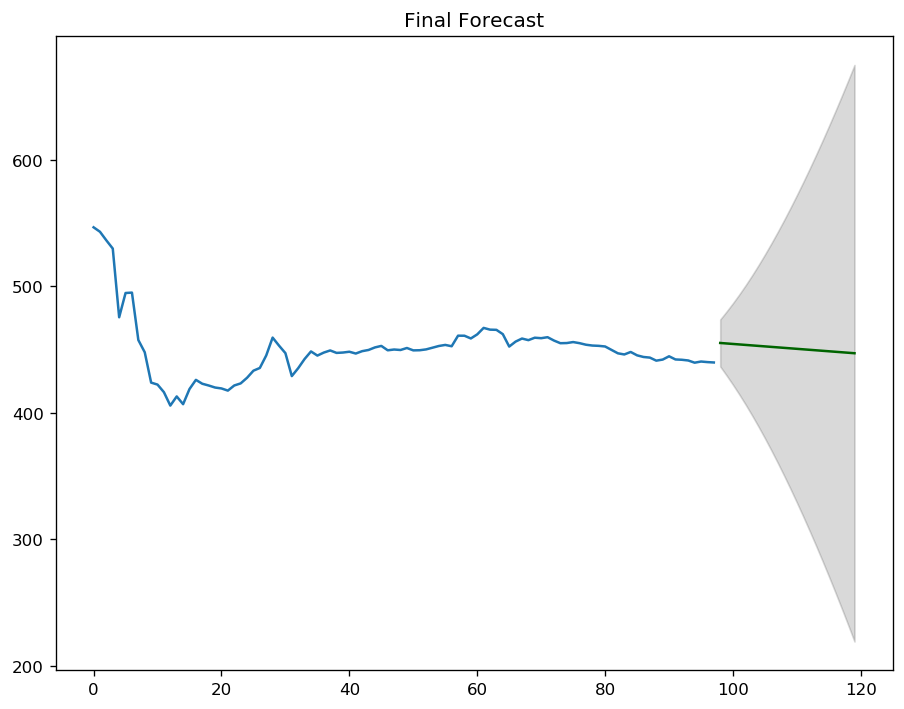

In [99]:
# Forecast
n_periods = 22
fc, confint = model_bulgaria.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(data_bulgaria), len(data_bulgaria)+n_periods)

# make series for plotting purpose
fc_series_bulgaria = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data_bulgaria)
plt.plot(fc_series_bulgaria, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

# Ucrania

In [103]:
data_ucrania = data_completed_new[data_completed_new['Country/Region'] == 'Ukraine']
del data_ucrania['Country/Region']

In [104]:
data_ucrania= data_ucrania['Bolsa']

In [105]:
data_ucrania=data_ucrania[::-1]

data_ucrania=pd.DataFrame(data_ucrania)
data_ucrania.reset_index(inplace=True)
del data_ucrania['index']

In [106]:
data_ucrania= data_ucrania['Bolsa']

#### Estacionariedad

In [ ]:
result = adfuller(data_ucrania)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_ucrania); axes[0, 0].set_title('Original Series')
plot_acf(data_ucrania, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_ucrania.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_ucrania.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_ucrania.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_ucrania.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
## Adf Test
ndiffs(data_ucrania, test='adf')

In [107]:
# Create Training and Test
train_ucrania = data_ucrania[:76]
test_ucrania = data_ucrania[76:] # 21 datos

## Auto-ARIMA

In [115]:
model_ucrania = pm.auto_arima(data_ucrania, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stationary= False,
                      stepwise=True)


print(model_ucrania.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1484.913, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=361.201, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=361.648, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=363.101, Time=0.21 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.045 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -177.601
Date:           

In [ ]:
model_ucrania.plot_diagnostics(figsize=(7,5))
plt.show()

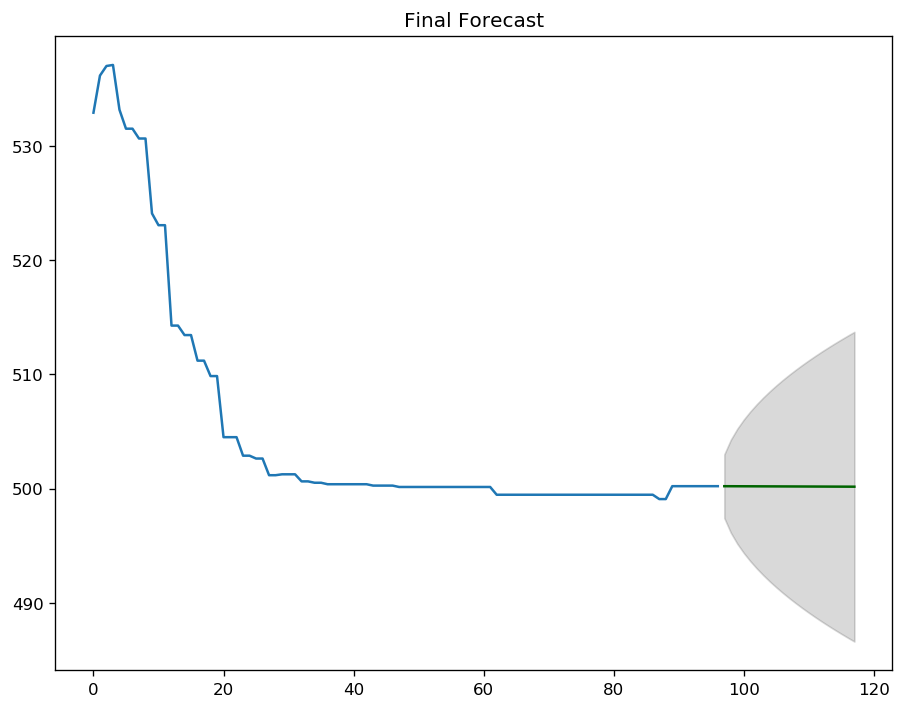

In [116]:
# Forecast
n_periods = 21
fc, confint = model_ucrania.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(data_ucrania), len(data_ucrania)+n_periods)

# make series for plotting purpose
fc_series_ucrania = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data_ucrania)
plt.plot(fc_series_ucrania, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

In [117]:
rmse(test_ucrania, fc_series_ucrania)

0.633414349562928

                             ARIMA Model Results                              
Dep. Variable:                D.Bolsa   No. Observations:                   75
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -512.933
Method:                       css-mle   S.D. of innovations            225.874
Date:                Sun, 05 Dec 2021   AIC                           1033.866
Time:                        20:45:18   BIC                           1043.136
Sample:                             1   HQIC                          1037.567
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -18.0105     24.158     -0.746      0.456     -65.360      29.339
ar.L1.D.Bolsa    -0.5995      0.256     -2.340      0.019      -1.102      -0.097
ma.L1.D.Bolsa     0.4806      0.267     

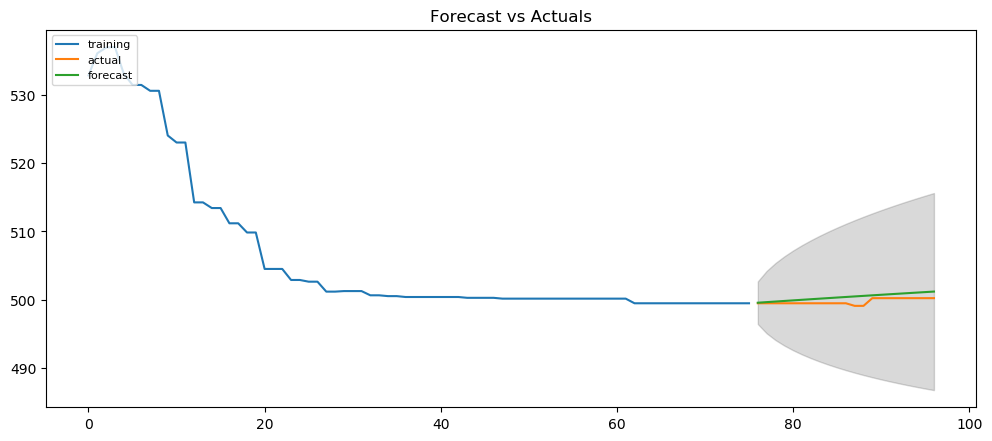

In [113]:
# Build Model
model_ucrania = ARIMA(train_ucrania, order=(1, 0, 1))  
fitted_ucrania = model_ucrania.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted_ucrania.forecast(21, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_ucrania = pd.Series(fc, index=test_ucrania.index)
lower_series = pd.Series(conf[:, 0], index=test_ucrania.index)
upper_series = pd.Series(conf[:, 1], index=test_ucrania.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_ucrania, label='training')
plt.plot(test_ucrania, label='actual')
plt.plot(fc_series_ucrania, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Portugal

In [120]:
data_portugal = data_completed_new[data_completed_new['Country/Region'] == 'Portugal']
del data_portugal['Country/Region']

In [121]:
data_portugal= data_portugal['Bolsa']

In [122]:
data_portugal=data_portugal[::-1]


data_portugal=pd.DataFrame(data_portugal)
data_portugal.reset_index(inplace=True)
del data_portugal['index']

In [123]:
data_portugal= data_portugal['Bolsa']

Estacionariedad

In [ ]:
result = adfuller(data_portugal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_portugal); axes[0, 0].set_title('Original Series')
plot_acf(data_portugal, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_portugal.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_portugal.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_portugal.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_portugal.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
## Adf Test
ndiffs(data_portugal, test='kpss')

In [124]:
# Create Training and Test
train_portugal = data_portugal[:76]
test_portugal = data_portugal[76:]

## Auto-ARIMA

In [125]:
model_portugal = pm.auto_arima(train_portugal, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stationary= False,
                      stepwise=True)


print(model_portugal.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=915.301, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=916.682, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=916.827, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=913.482, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=917.447, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.267 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -455.741
Date:                Sun, 05 Dec 2021   AIC                            913.482
Time:                        20:47:12   BIC                            915.800
Sample:                             0   HQIC                           914.408
                                 - 76                                         
Co

In [ ]:
model_portugal.plot_diagnostics(figsize=(7,5))
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Bolsa   No. Observations:                   75
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -455.651
Method:                           css   S.D. of innovations            105.257
Date:                Sun, 05 Dec 2021   AIC                            915.301
Time:                        20:54:23   BIC                            919.936
Sample:                             1   HQIC                           917.152
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1717     12.154     -0.426      0.670     -28.993      18.650


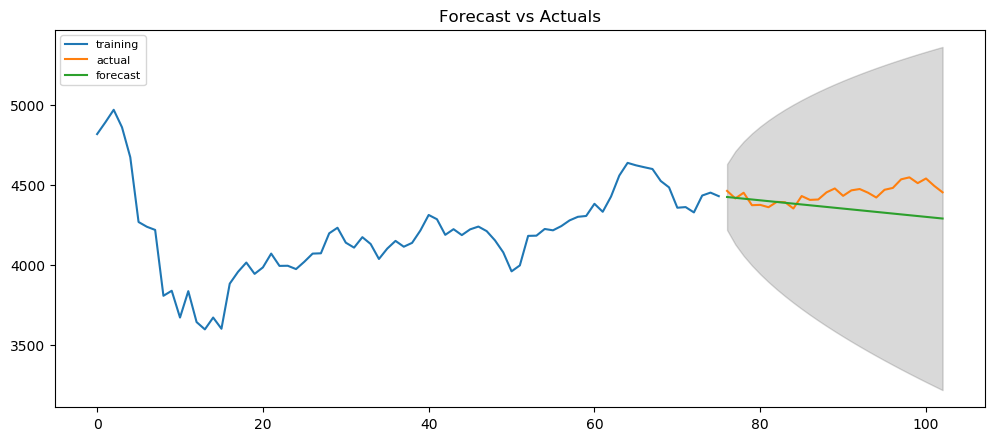

In [126]:
# Build Model
model_portugal = ARIMA(train_portugal, order=(0, 1, 0))  
fitted_portugal = model_portugal.fit(disp=-1)  
print(fitted_portugal.summary())

# Forecast
fc, se, conf = fitted_portugal.forecast(27, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_portugal = pd.Series(fc, index=test_portugal.index)
lower_series = pd.Series(conf[:, 0], index=test_portugal.index)
upper_series = pd.Series(conf[:, 1], index=test_portugal.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_portugal, label='training')
plt.plot(test_portugal, label='actual')
plt.plot(fc_series_portugal, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


Suecia

In [128]:
data_sweden = data_completed_new[data_completed_new['Country/Region'] == 'Sweden']
del data_sweden['Country/Region']

In [129]:
data_sweden= data_sweden['Bolsa']

In [130]:
data_sweden=data_sweden[::-1]


data_sweden=pd.DataFrame(data_sweden)
data_sweden.reset_index(inplace=True)
del data_sweden['index']

In [131]:
data_sweden= data_sweden['Bolsa']

#### Estacionariedad

In [ ]:
result = adfuller(data_sweden)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_sweden); axes[0, 0].set_title('Original Series')
plot_acf(data_sweden, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_sweden.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_sweden.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_sweden.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_sweden.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
## Adf Test
#ndiffs(data_sweden, test='adf')  # 2

# KPSS test
#ndiffs(data_sweden, test='kpss')  # 0

# PP test:
#ndiffs(data_sweden, test='pp')  # 2

In [132]:
# Create Training and Test
train_sweden = data_sweden[:76]
test_sweden = data_sweden[76:] # 25 periodos

In [133]:
model_sweden = pm.auto_arima(train_sweden, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stationary= False,
                      stepwise=True)


print(model_sweden.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1019.567, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1021.554, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1021.555, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1017.579, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.482 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -507.789
Date:                Sun, 05 Dec 2021   AIC                           1017.579
Time:                        20:57:59   BIC                           1019.896
Sample:                             0   HQIC                          1018.504
                                 - 76                                         
Co

In [ ]:
model_sweden.plot_diagnostics(figsize=(7,5))
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Bolsa   No. Observations:                   75
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -507.783
Method:                           css   S.D. of innovations            210.926
Date:                Sun, 05 Dec 2021   AIC                           1019.567
Time:                        20:58:39   BIC                           1024.202
Sample:                             1   HQIC                          1021.417
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6707     24.356      0.110      0.913     -45.065      50.407


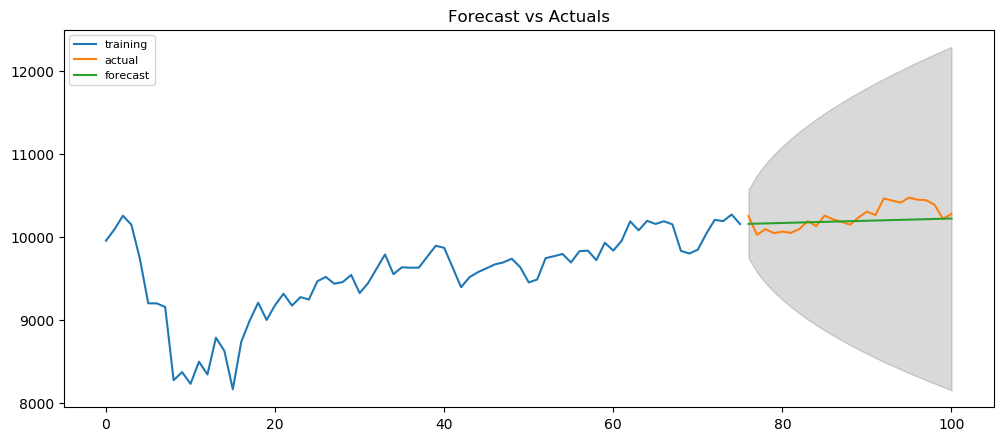

In [135]:
# Build Model
model_sweden = ARIMA(train_sweden, order=(0, 1, 0))  
fitted_sweden = model_sweden.fit(disp=-1)  
print(fitted_sweden.summary())

# Forecast
fc, se, conf = fitted_sweden.forecast(25, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_sweden = pd.Series(fc, index=test_sweden.index)
lower_series = pd.Series(conf[:, 0], index=test_sweden.index)
upper_series = pd.Series(conf[:, 1], index=test_sweden.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_sweden, label='training')
plt.plot(test_sweden, label='actual')
plt.plot(fc_series_sweden, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()



# Alemania

In [137]:
data_germany = data_completed_new[data_completed_new['Country/Region'] == 'Germany']
del data_germany['Country/Region']

In [138]:
data_germany= data_germany['Bolsa']

In [139]:
data_germany=data_germany[::-1]


data_germany=pd.DataFrame(data_germany)
data_germany.reset_index(inplace=True)
del data_germany['index']

In [140]:
data_germany= data_germany['Bolsa']

#### Estacionariedad

In [ ]:
result = adfuller(data_germany)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_germany); axes[0, 0].set_title('Original Series')
plot_acf(data_germany, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_germany.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_germany.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_germany.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_germany.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
## Adf Test
ndiffs(data_germany, test='adf')

In [ ]:
# KPSS test
ndiffs(data_germany, test='kpss')  # 0

In [141]:
# Create Training and Test
train_germany = data_germany[:76]
test_germany = data_germany[76:]

# Auti-ARIMA

In [142]:
model_germany = pm.auto_arima(train_germany, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stationary= False,
                      stepwise=True)


print(model_germany.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1086.437, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1088.267, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1088.300, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1084.464, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.319 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -541.232
Date:                Sun, 05 Dec 2021   AIC                           1084.464
Time:                        21:00:10   BIC                           1086.782
Sample:                             0   HQIC                          1085.390
                                 - 76                                         
Co

In [ ]:
model_germany.plot_diagnostics(figsize=(7,5))
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Bolsa   No. Observations:                   75
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -541.218
Method:                           css   S.D. of innovations            329.411
Date:                Sun, 05 Dec 2021   AIC                           1086.437
Time:                        21:00:38   BIC                           1091.072
Sample:                             1   HQIC                          1088.288
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3052     38.037      0.166      0.868     -68.246      80.857


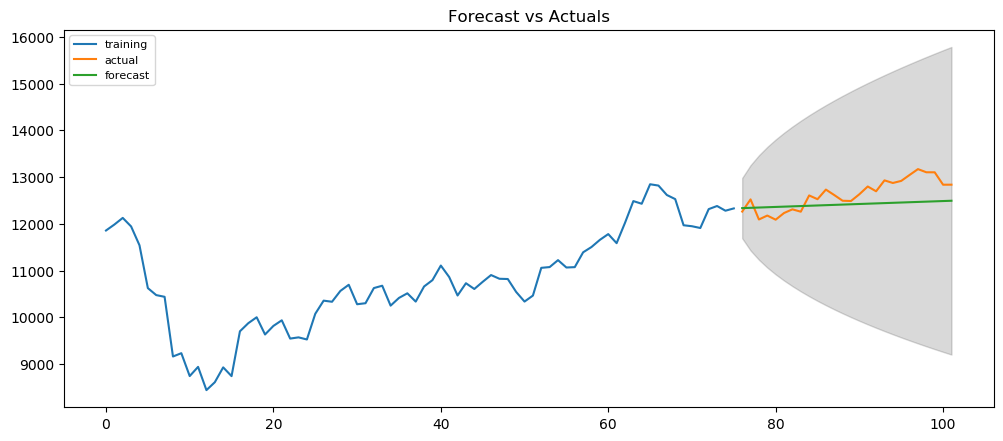

In [143]:
# Build Model
model_germany = ARIMA(train_germany, order=(0, 1, 0))  
fitted_germany = model_germany.fit(disp=-1)  
print(fitted_germany.summary())

# Forecast
fc, se, conf = fitted_germany.forecast(26, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_germany = pd.Series(fc, index=test_germany.index)
lower_series = pd.Series(conf[:, 0], index=test_germany.index)
upper_series = pd.Series(conf[:, 1], index=test_germany.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_germany, label='training')
plt.plot(test_germany, label='actual')
plt.plot(fc_series_germany, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Recurrent Neural Net

### España

In [835]:
rnn_spain= data_completed_new[data_completed_new['Country/Region'] == 'Spain']
del rnn_spain['Country/Region']
del rnn_spain['Date']

In [836]:
rnn_spain= rnn_spain[::-1]
rnn_spain.reset_index(inplace=True)
del rnn_spain['index']

In [837]:
# 103 valores Spain
# Create Training and Test
train_spain = rnn_spain[:76]
test_spain = rnn_spain[76:]

In [838]:
# Escalar datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_spain)

X_train_spain_scaled = pd.DataFrame(scaler.transform(train_spain), columns= rnn_spain.columns)
X_test_spain_scaled = pd.DataFrame(scaler.transform(test_spain), columns= rnn_spain.columns)

In [839]:
# separación Y test

y = X_train_spain_scaled["Bolsa"]

X = X_train_spain_scaled.drop("Bolsa", axis=1)

In [840]:
dataset_train= X.copy()
dataset_train['Bolsa']= y

In [841]:
# separación Y test

y_test = X_test_spain_scaled["Bolsa"]

X_test = X_test_spain_scaled.drop("Bolsa", axis=1)

In [842]:
dataset_test= X_test.copy()
dataset_test['Bolsa']= y_test

## RNN

In [843]:
from keras.models import Sequential
from keras.layers import  LSTM, Dense, Dropout, Masking, Embedding
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Prueba modelo 1

In [844]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 15
# convert into input/output
X, y = split_sequences(dataset_train, n_steps)
print(X.shape, y.shape)
# summarize the data
#for i in range(len(X)):

    #print(X[i], y[i])

(62, 15, 10) (62,)


In [845]:
#Initialize RNN:
from keras.layers import SimpleRNN
from keras.layers import LSTM

regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape= (X.shape[1], X.shape[2])
                ))
regressor.add(Dropout(0.2))

In [846]:
#Adding the second RNN layer and some Dropout regularization
regressor.add(LSTM(units = 100, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

In [847]:
#Adding the third RNN layer and some Dropout regularization
regressor.add(LSTM(units = 60, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [848]:
#Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
history= regressor.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

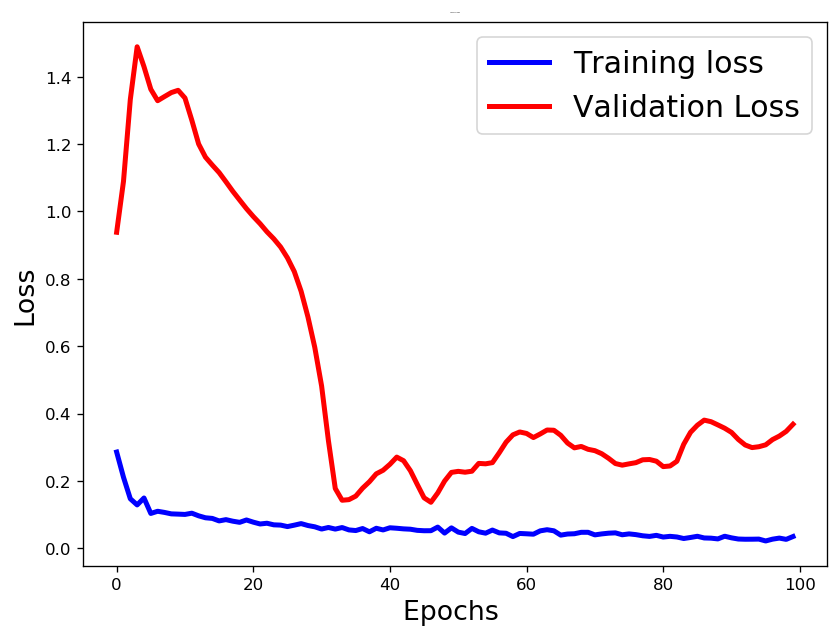

In [849]:
#Plot the loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'b',linewidth=3.0)
plt.plot(history.history['val_loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=1)
plt.show()

In [850]:
# transforming test data
X_test, y_test = split_sequences(dataset_test, n_steps)

In [851]:
real_price= y_test

predicted_price = regressor.predict(X_test)

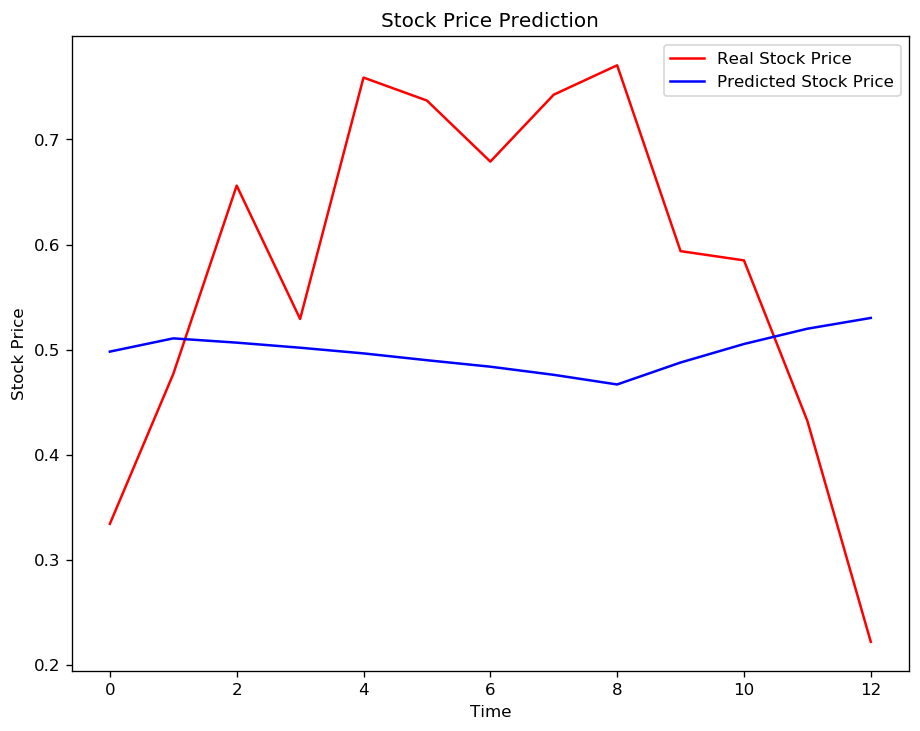

In [852]:
plt.plot(real_price, color='red', label='Real Stock Price')
plt.plot(predicted_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [874]:
# probamos a predecir sobre todo el conjunto de train para ver si el modelo está sobreajustando
real_price_train= y[::-1]

predicted_price_train = regressor.predict(X[::-1])


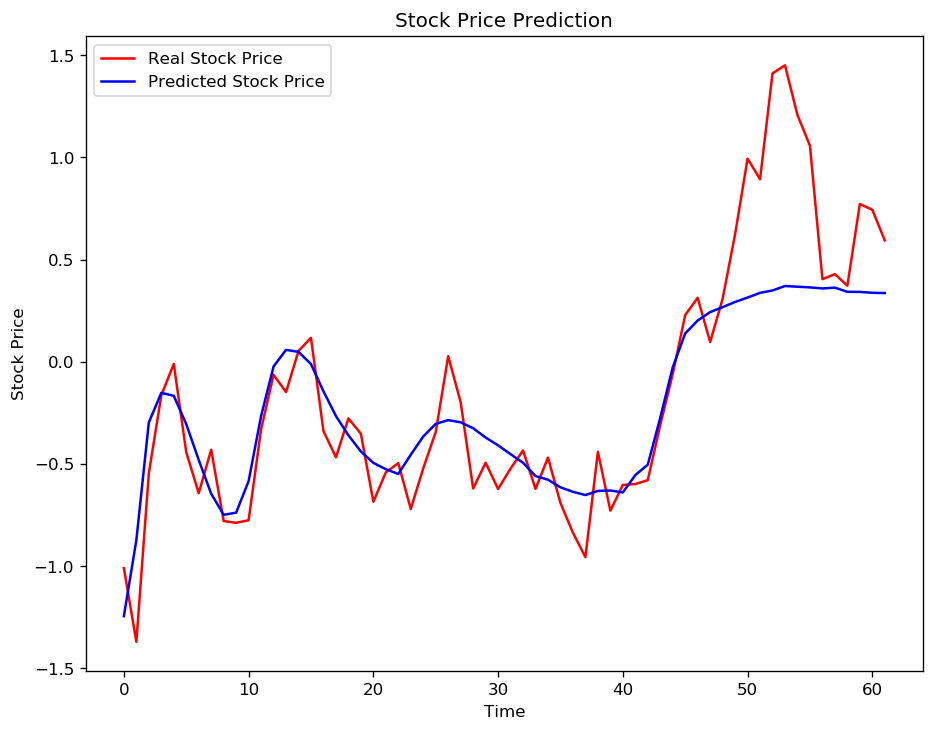

In [875]:
plt.plot(real_price_train, color='red', label='Real Stock Price')
plt.plot(predicted_price_train, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Escenarios

#### Bulgaria

In [998]:
rnn_bulgaria= data_completed_new[data_completed_new['Country/Region'] == 'Bulgaria']
del rnn_bulgaria['Country/Region']
del rnn_bulgaria['Date']

In [999]:
rnn_bulgaria= rnn_bulgaria[::-1]
rnn_bulgaria.reset_index(inplace=True)
del rnn_bulgaria['index']

In [1000]:
# Create Training and Test
train_bulgaria = rnn_bulgaria[:78]
test_bulgaria = rnn_bulgaria[78:]

In [1001]:
# Escalar datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_bulgaria)

X_train_bulgaria_scaled = pd.DataFrame(scaler.transform(train_bulgaria), columns= rnn_bulgaria.columns)
X_test_bulgaria_scaled = pd.DataFrame(scaler.transform(test_bulgaria), columns= rnn_bulgaria.columns)

In [1002]:
# separación Y test

y = X_train_bulgaria_scaled["Bolsa"]

X = X_train_bulgaria_scaled.drop("Bolsa", axis=1)

In [1003]:
dataset_train= X.copy()
dataset_train['Bolsa']= y

In [1004]:
# separación Y test

y_test = X_test_bulgaria_scaled["Bolsa"]

X_test = X_test_bulgaria_scaled.drop("Bolsa", axis=1)

In [1005]:
dataset_test= X_test.copy()
dataset_test['Bolsa']= y_test

In [1006]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 15
# convert into input/output
X, y = split_sequences(dataset_train, n_steps)
print(X.shape, y.shape)
# summarize the data
#for i in range(len(X)):

    #print(X[i], y[i])

(64, 15, 10) (64,)


In [1007]:
#Initialize RNN:
from keras.layers import SimpleRNN
from keras.layers import LSTM

regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape= (X.shape[1], X.shape[2])
                ))
regressor.add(Dropout(0.2))

In [1008]:
#Adding the second RNN layer and some Dropout regularization
regressor.add(LSTM(units = 100, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

In [1009]:
#Adding the third RNN layer and some Dropout regularization
regressor.add(LSTM(units = 60, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [1010]:
#Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
history= regressor.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

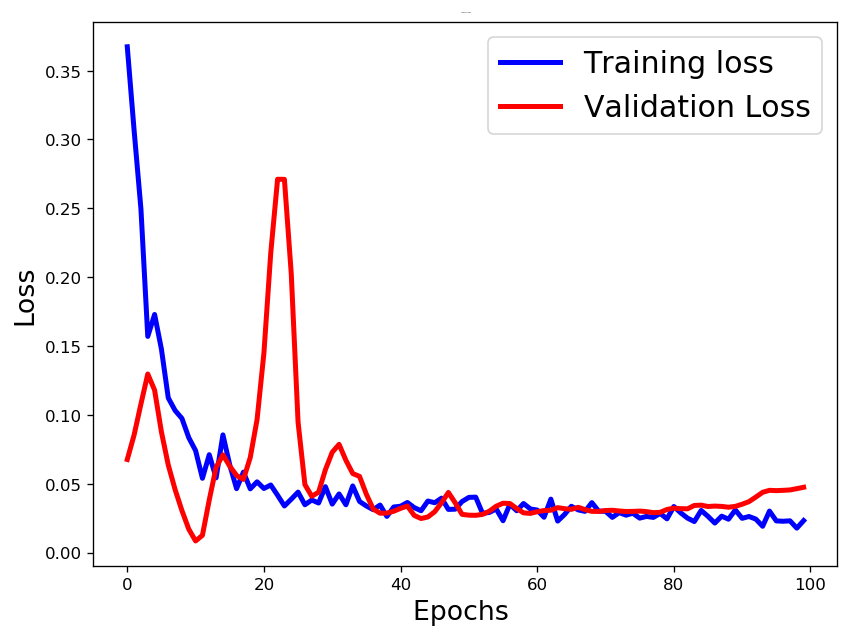

In [1011]:
#Plot the loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'b',linewidth=3.0)
plt.plot(history.history['val_loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=1)
plt.show()

In [1019]:
# transforming test data
X_test, y_test = split_sequences(dataset_test, n_steps)

In [1020]:
real_price= y_test

predicted_price = regressor.predict(X_test)

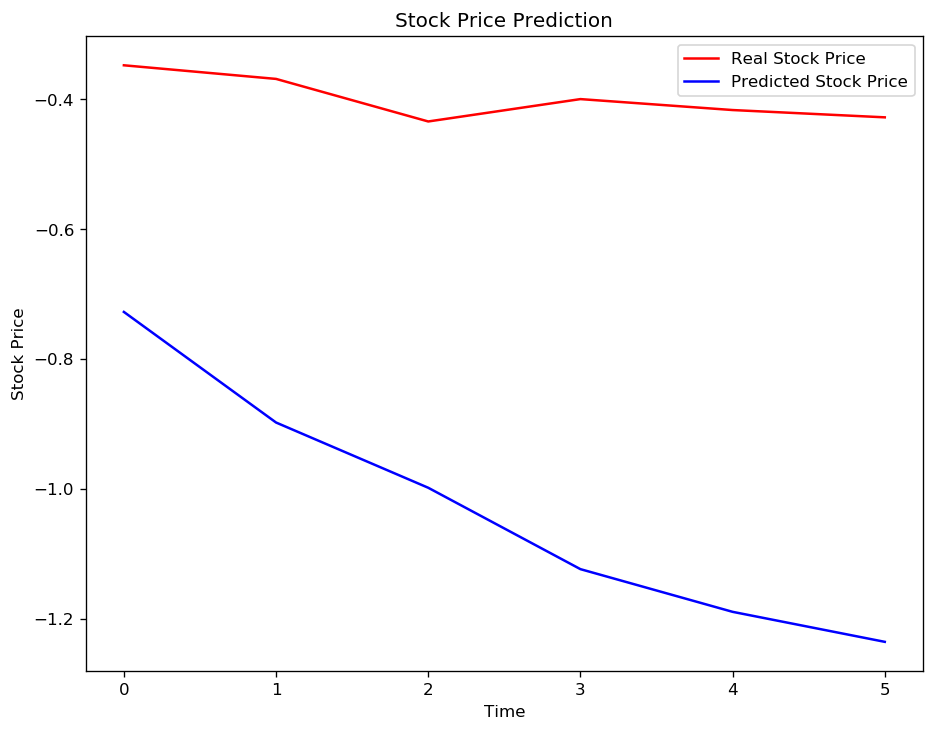

In [1021]:
plt.plot(real_price, color='red', label='Real Stock Price')
plt.plot(predicted_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [1015]:
# probamos a predecir sobre todo el conjunto de train para ver si el modelo está sobreajustando
#real_price_train= y[::-1]

#predicted_price_train = regressor.predict(X[::-1])

In [1016]:
#plt.plot(real_price_train, color='red', label='Real Stock Price')
#plt.plot(predicted_price_train, color='blue', label='Predicted Stock Price')
#plt.title('Stock Price Prediction')
#plt.xlabel('Time')
#plt.ylabel('Stock Price')
#plt.legend()
#plt.show()

#### Ucrania

In [1017]:
rnn_ucrania= data_completed_new[data_completed_new['Country/Region'] == 'Ukraine']
del rnn_ucrania['Country/Region']
del rnn_ucrania['Date']

In [1018]:
rnn_ucrania= rnn_ucrania[::-1]
rnn_ucrania.reset_index(inplace=True)
del rnn_ucrania['index']

In [981]:
# Create Training and Test
train_ucrania = rnn_ucrania[:77]
test_ucrania = rnn_ucrania[77:]

In [982]:
# revertimos el orden de los datos
#train_ucrania= train_ucrania[::-1]
#test_ucrania= test_ucrania[::-1]

In [983]:
# Escalar datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_ucrania)

X_train_ucrania_scaled = pd.DataFrame(scaler.transform(train_ucrania), columns= rnn_ucrania.columns)
X_test_ucrania_scaled = pd.DataFrame(scaler.transform(test_ucrania), columns= rnn_ucrania.columns)

In [984]:
# separación Y test

y = X_train_ucrania_scaled["Bolsa"]

X = X_train_ucrania_scaled.drop("Bolsa", axis=1)

In [985]:
dataset_train= X.copy()
dataset_train['Bolsa']= y

In [986]:
# separación Y test

y_test = X_test_ucrania_scaled["Bolsa"]

X_test = X_test_ucrania_scaled.drop("Bolsa", axis=1)

In [987]:
dataset_test= X_test.copy()
dataset_test['Bolsa']= y_test

In [988]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 7
# convert into input/output
X, y = split_sequences(dataset_train, n_steps)
print(X.shape, y.shape)
# summarize the data
#for i in range(len(X)):

    #print(X[i], y[i])

(71, 7, 10) (71,)


In [989]:
#Initialize RNN:
from keras.layers import SimpleRNN
from keras.layers import LSTM

regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape= (X.shape[1], X.shape[2])
                ))
regressor.add(Dropout(0.2))

In [990]:
#Adding the second RNN layer and some Dropout regularization
regressor.add(LSTM(units = 100, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

In [991]:
#Adding the third RNN layer and some Dropout regularization
regressor.add(LSTM(units = 60, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [992]:
#Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
history= regressor.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

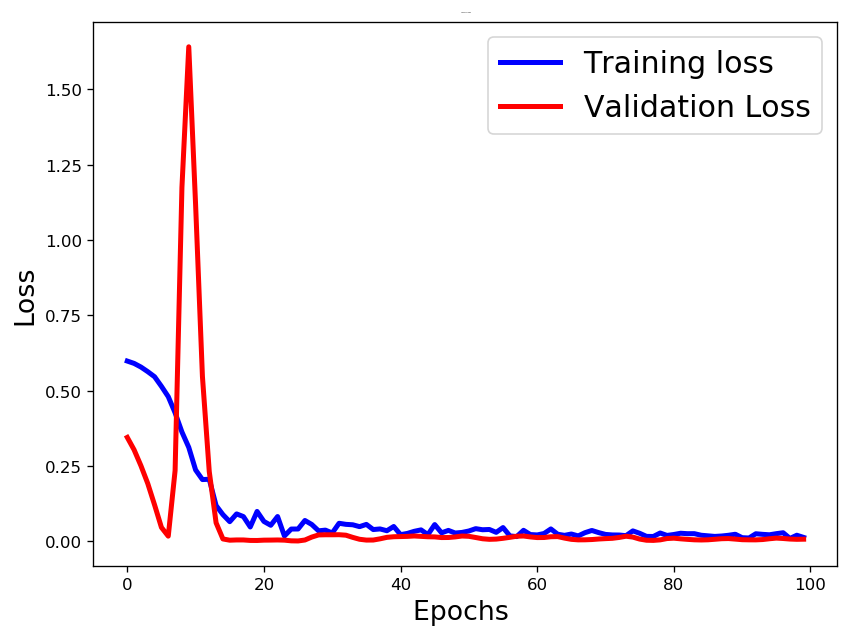

In [993]:
#Plot the loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'b',linewidth=3.0)
plt.plot(history.history['val_loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=1)
plt.show()

In [994]:
# transforming test data
X_test, y_test = split_sequences(dataset_test, n_steps)

In [995]:
real_price= y_test

predicted_price = regressor.predict(X_test)

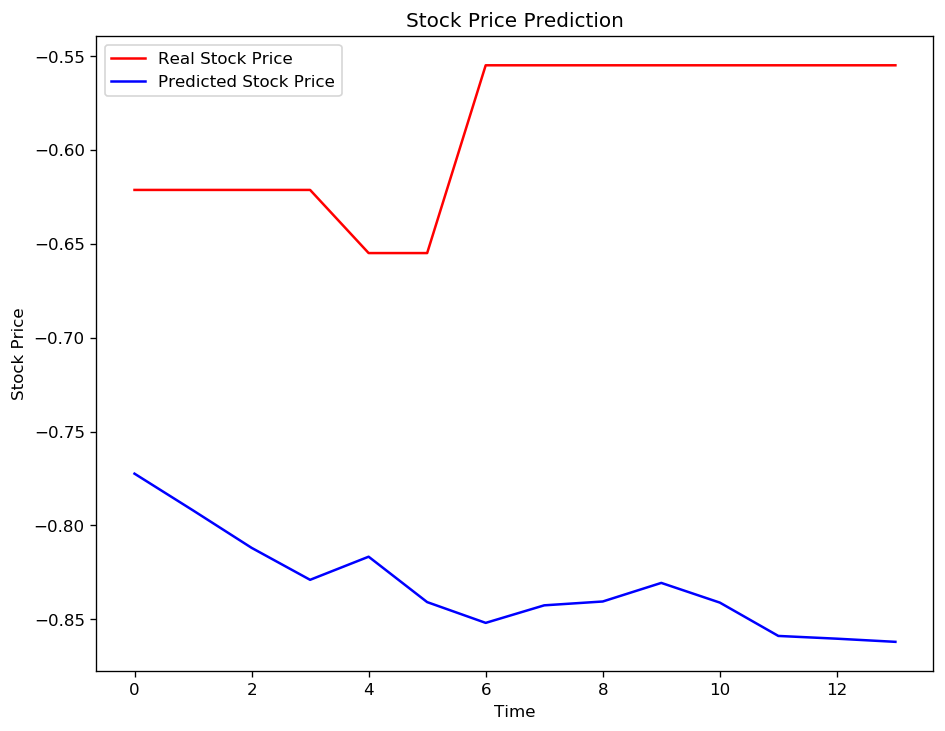

In [996]:
plt.plot(real_price, color='red', label='Real Stock Price')
plt.plot(predicted_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [978]:
# probamos a predecir sobre todo el conjunto de train para ver si el modelo está sobreajustando
#real_price_train= y

#predicted_price_train = regressor.predict(X)

In [977]:
#plt.plot(real_price_train, color='red', label='Real Stock Price')
#plt.plot(predicted_price_train, color='blue', label='Predicted Stock Price')
#plt.title('Stock Price Prediction')
#plt.xlabel('Time')
#plt.ylabel('Stock Price')
#plt.legend()
#plt.show()

#### Portugal

In [959]:
rnn_portugal= data_completed_new[data_completed_new['Country/Region'] == 'Portugal']
del rnn_portugal['Country/Region']
del rnn_portugal['Date']

In [960]:
rnn_portugal= rnn_portugal[::-1]
rnn_portugal.reset_index(inplace=True)
del rnn_portugal['index']

In [961]:
# Create Training and Test
train_portugal = rnn_portugal[:82]
test_portugal = rnn_portugal[82:]

In [962]:
# revertimos el orden de los datos
#train_portugal= train_portugal[::-1]
#test_portugal= test_portugal[::-1]

In [963]:
# Escalar datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_portugal)

X_train_portugal_scaled = pd.DataFrame(scaler.transform(train_portugal), columns= rnn_portugal.columns)
X_test_portugal_scaled = pd.DataFrame(scaler.transform(test_portugal), columns= rnn_portugal.columns)

In [964]:
# separación Y test

y = X_train_portugal_scaled["Bolsa"]

X = X_train_portugal_scaled.drop("Bolsa", axis=1)

In [965]:
dataset_train= X.copy()
dataset_train['Bolsa']= y

In [966]:
# separación Y test

y_test = X_test_portugal_scaled["Bolsa"]

X_test = X_test_portugal_scaled.drop("Bolsa", axis=1)

In [967]:
dataset_test= X_test.copy()
dataset_test['Bolsa']= y_test

### Modelo

In [968]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 15
# convert into input/output
X, y = split_sequences(dataset_train, n_steps)
print(X.shape, y.shape)
# summarize the data
#for i in range(len(X)):

    #print(X[i], y[i])

(68, 15, 10) (68,)


In [969]:
#Initialize RNN:
from keras.layers import SimpleRNN
from keras.layers import LSTM

regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape= (X.shape[1], X.shape[2])
                ))
regressor.add(Dropout(0.2))

In [970]:
#Adding the second RNN layer and some Dropout regularization
regressor.add(LSTM(units = 100, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

In [971]:
#Adding the third RNN layer and some Dropout regularization
regressor.add(LSTM(units = 60, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [972]:
#Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
history= regressor.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

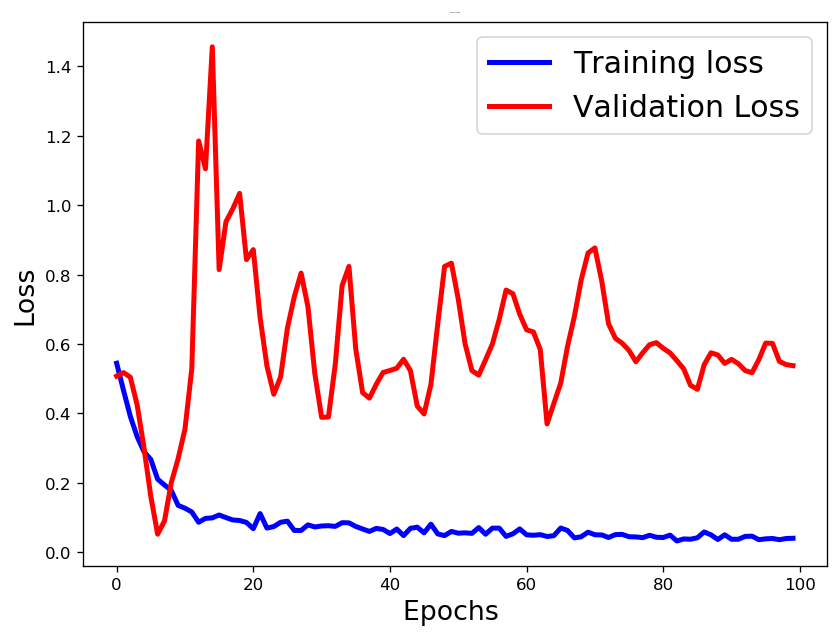

In [973]:
#Plot the loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'b',linewidth=3.0)
plt.plot(history.history['val_loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=1)
plt.show()

In [974]:
# transforming test data
X_test, y_test = split_sequences(dataset_test, n_steps)

In [975]:
real_price= y_test

predicted_price = regressor.predict(X_test)

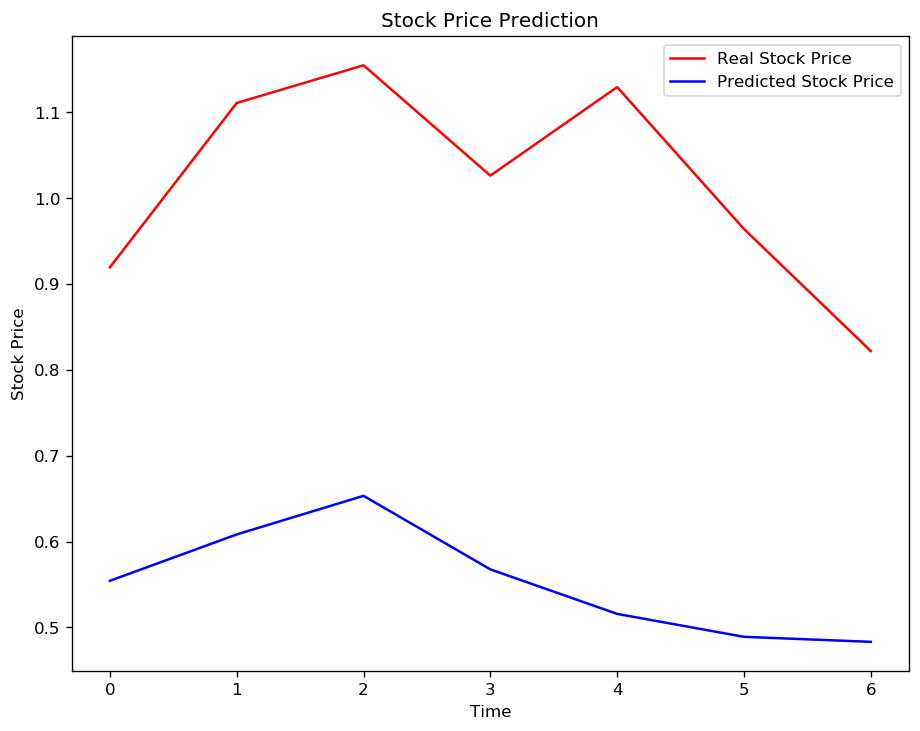

In [976]:
plt.plot(real_price, color='red', label='Real Stock Price')
plt.plot(predicted_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [544]:
# probamos a predecir sobre todo el conjunto de train para ver si el modelo está sobreajustando
#real_price_train= y

#predicted_price_train = regressor.predict(X)

In [958]:
#plt.plot(real_price_train, color='red', label='Real Stock Price')
#plt.plot(predicted_price_train, color='blue', label='Predicted Stock Price')
#plt.title('Stock Price Prediction')
#plt.xlabel('Time')
#plt.ylabel('Stock Price')
#plt.legend()
#plt.show()

#### Suecia 

In [939]:
rnn_sweden= data_completed_new[data_completed_new['Country/Region'] == 'Sweden']
del rnn_sweden['Country/Region']
del rnn_sweden['Date']

In [940]:
rnn_sweden= rnn_sweden[::-1]
rnn_sweden.reset_index(inplace=True)
del rnn_sweden['index']

In [941]:
# Create Training and Test
train_sweden = rnn_sweden[:80]
test_sweden = rnn_sweden[80:]

In [942]:
# revertimos el orden de los datos
train_sweden= train_sweden[::-1]
test_sweden= test_sweden[::-1]

In [943]:
# Escalar datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_sweden)

X_train_sweden_scaled = pd.DataFrame(scaler.transform(train_sweden), columns= rnn_sweden.columns)
X_test_sweden_scaled = pd.DataFrame(scaler.transform(test_sweden), columns= rnn_sweden.columns)

In [944]:
# separación Y test

y = X_train_sweden_scaled["Bolsa"]

X = X_train_sweden_scaled.drop("Bolsa", axis=1)

In [945]:
dataset_train= X.copy()
dataset_train['Bolsa']= y

In [946]:
# separación Y test

y_test = X_test_sweden_scaled["Bolsa"]

X_test = X_test_sweden_scaled.drop("Bolsa", axis=1)

In [947]:
dataset_test= X_test.copy()
dataset_test['Bolsa']= y_test

Modelo

In [948]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 15
# convert into input/output
X, y = split_sequences(dataset_train, n_steps)
print(X.shape, y.shape)
# summarize the data
#for i in range(len(X)):

    #print(X[i], y[i])

(66, 15, 10) (66,)


In [949]:
#Initialize RNN:
from keras.layers import SimpleRNN
from keras.layers import LSTM

regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape= (X.shape[1], X.shape[2])
                ))
regressor.add(Dropout(0.2))

In [950]:
#Adding the second RNN layer and some Dropout regularization
regressor.add(LSTM(units = 100, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

In [951]:
#Adding the third RNN layer and some Dropout regularization
regressor.add(LSTM(units = 60, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [952]:
#Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
history= regressor.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

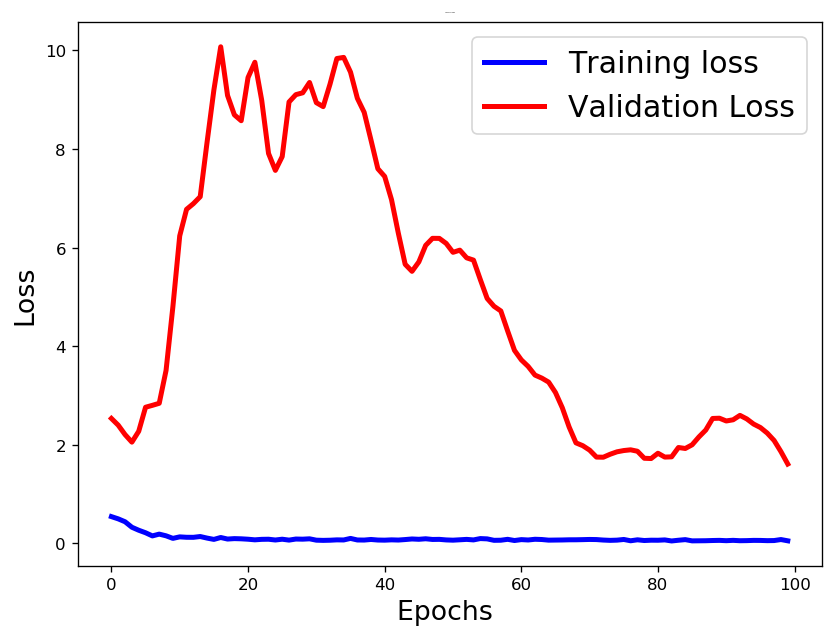

In [953]:
#Plot the loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'b',linewidth=3.0)
plt.plot(history.history['val_loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=1)
plt.show()

In [954]:
# transforming test data
X_test, y_test = split_sequences(dataset_test, n_steps)

In [955]:
real_price= y_test

predicted_price = regressor.predict(X_test)

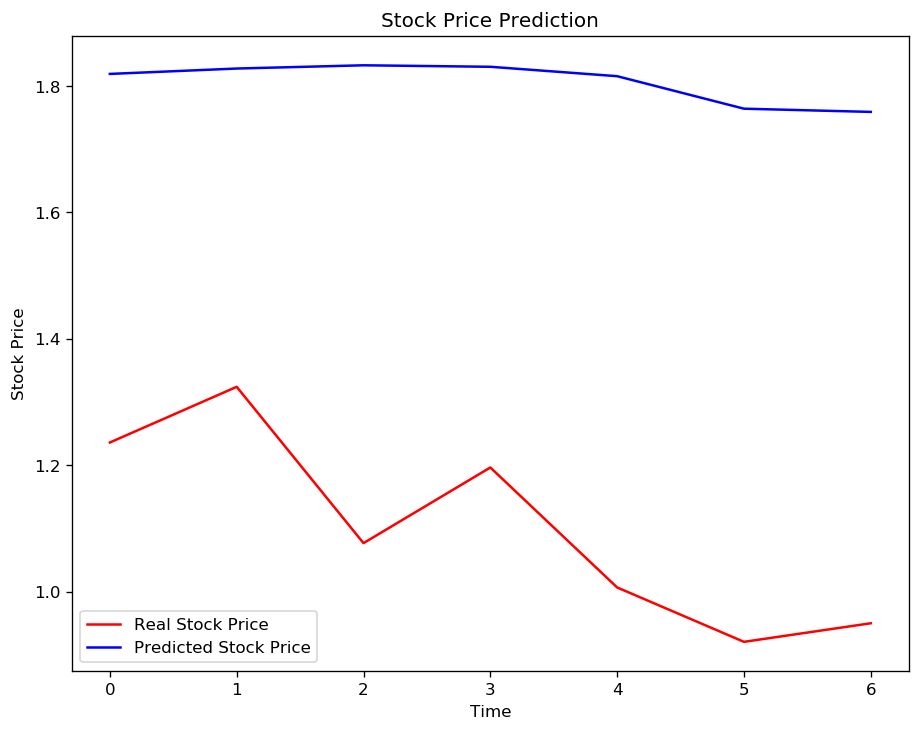

In [956]:
plt.plot(real_price, color='red', label='Real Stock Price')
plt.plot(predicted_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [588]:
# probamos a predecir sobre todo el conjunto de train para ver si el modelo está sobreajustando
#real_price_train= y

#predicted_price_train = regressor.predict(X)

In [938]:
#plt.plot(real_price_train, color='red', label='Real Stock Price')
#plt.plot(predicted_price_train, color='blue', label='Predicted Stock Price')
#plt.title('Stock Price Prediction')
#plt.xlabel('Time')
#plt.ylabel('Stock Price')
#plt.legend()
#plt.show()

#### Alemania

In [921]:
rnn_germany= data_completed_new[data_completed_new['Country/Region'] == 'Germany']
del rnn_germany['Country/Region']
del rnn_germany['Date']

In [922]:
rnn_germany= rnn_germany[::-1]
rnn_germany.reset_index(inplace=True)
del rnn_germany['index']

In [900]:
# Create Training and Test
train_germany = rnn_germany[:81]
test_germany = rnn_germany[81:]

In [923]:
# revertimos el orden de los datos
#train_germany= train_germany[::-1]
#test_germany= test_germany[::-1]

In [924]:
# Escalar datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_germany)

X_train_germany_scaled = pd.DataFrame(scaler.transform(train_germany), columns= rnn_germany.columns)
X_test_germany_scaled = pd.DataFrame(scaler.transform(test_germany), columns= rnn_germany.columns)

In [925]:
# separación Y test

y = X_train_germany_scaled["Bolsa"]

X = X_train_germany_scaled.drop("Bolsa", axis=1)

In [926]:
dataset_train= X.copy()
dataset_train['Bolsa']= y

In [927]:
# separación Y test

y_test = X_test_germany_scaled["Bolsa"]

X_test = X_test_germany_scaled.drop("Bolsa", axis=1)

In [928]:
dataset_test= X_test.copy()
dataset_test['Bolsa']= y_test

Modelo

In [929]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 15
# convert into input/output
X, y = split_sequences(dataset_train, n_steps)
print(X.shape, y.shape)
# summarize the data
#for i in range(len(X)):

    #print(X[i], y[i])

(67, 15, 10) (67,)


In [930]:
#Initialize RNN:
from keras.layers import SimpleRNN
from keras.layers import LSTM

regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape= (X.shape[1], X.shape[2])
                ))
regressor.add(Dropout(0.2))

In [931]:
#Adding the second RNN layer and some Dropout regularization
regressor.add(LSTM(units = 100, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

In [932]:
#Adding the third RNN layer and some Dropout regularization
regressor.add(LSTM(units = 60, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [933]:
#Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
history= regressor.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

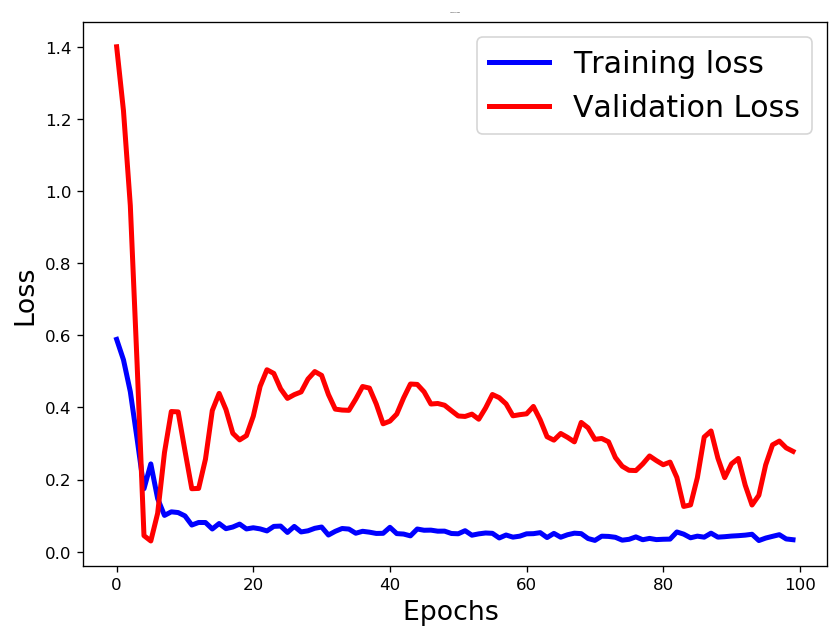

In [934]:
#Plot the loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'b',linewidth=3.0)
plt.plot(history.history['val_loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=1)
plt.show()

In [935]:
# transforming test data
X_test, y_test = split_sequences(dataset_test, n_steps)

In [936]:
real_price= y_test

predicted_price = regressor.predict(X_test)

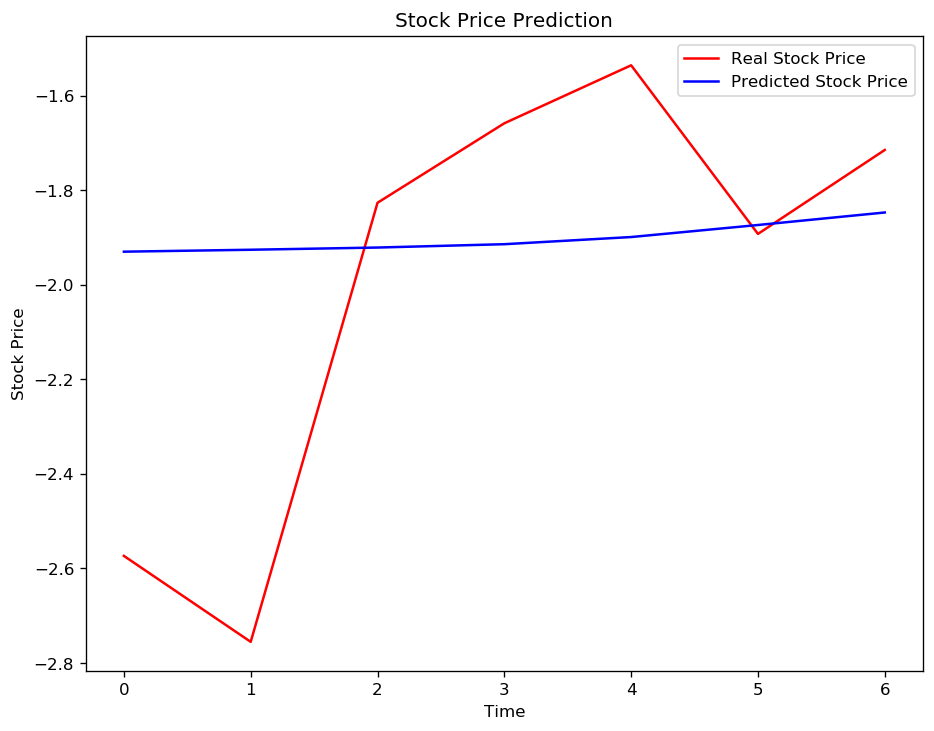

In [937]:
plt.plot(real_price, color='red', label='Real Stock Price')
plt.plot(predicted_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [634]:
# probamos a predecir sobre todo el conjunto de train para ver si el modelo está sobreajustando
#real_price_train= y

#predicted_price_train = regressor.predict(X)

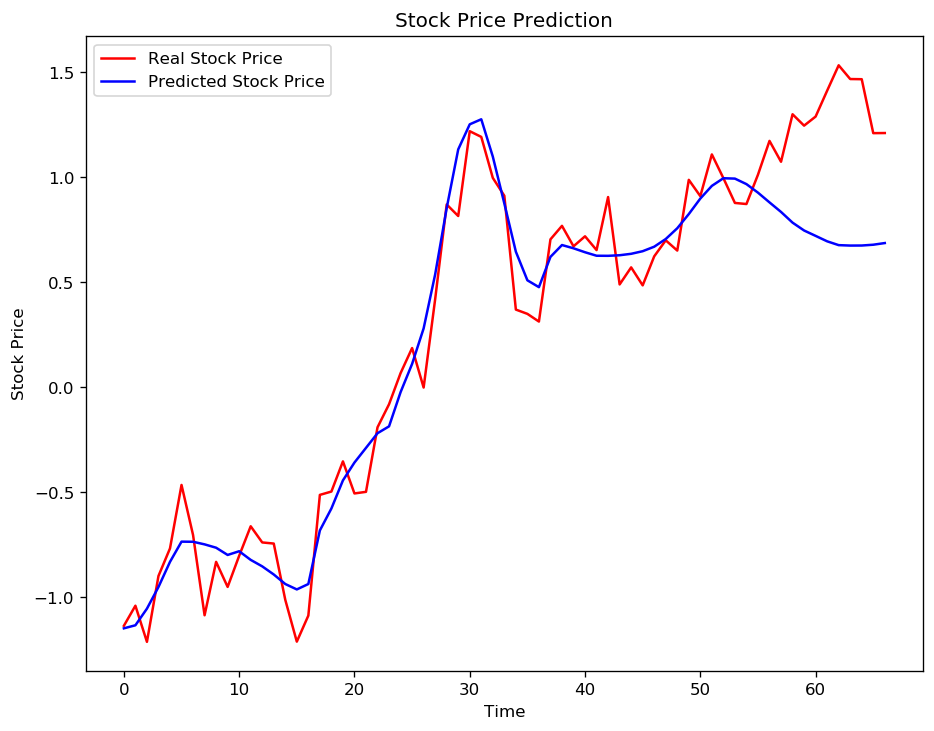

In [635]:
#plt.plot(real_price_train, color='red', label='Real Stock Price')
#plt.plot(predicted_price_train, color='blue', label='Predicted Stock Price')
#plt.title('Stock Price Prediction')
#plt.xlabel('Time')
#plt.ylabel('Stock Price')
#plt.legend()
#plt.show()